## Using pre-trained NN

In [270]:
# !conda install -y nomkl > tmp.log

In [271]:
import numpy as np
import theano
import theano.tensor as T
import lasagne
import cPickle as pickle
import os
import matplotlib.pyplot as plt
%matplotlib inline
import scipy
from scipy.misc import imread, imsave, imresize
from lasagne.utils import floatX

# Model Zoo
* https://github.com/Lasagne/Recipes/tree/master/modelzoo
* More models within the community
* Pick model, copy init, download weights
* Here we proceed with vgg16

In [34]:
!wget https://s3.amazonaws.com/lasagne/recipes/pretrained/imagenet/vgg16.pkl

--2017-05-28 01:41:12--  https://s3.amazonaws.com/lasagne/recipes/pretrained/imagenet/vgg16.pkl
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.18.3
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.18.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 553459517 (528M) [binary/octet-stream]
Saving to: ‘vgg16.pkl.1’

vgg16.pkl.1           0%[                    ]   1.73M   543KB/s    eta 16m 33s^C


In [272]:
# copyright: see http://www.robots.ox.ac.uk/~vgg/research/very_deep/


from lasagne.layers import InputLayer
from lasagne.layers import DenseLayer
from lasagne.layers import NonlinearityLayer
from lasagne.layers import DropoutLayer
from lasagne.layers import Pool2DLayer as PoolLayer
from lasagne.layers import Conv2DLayer as ConvLayer
from lasagne.nonlinearities import softmax


def build_model():
    net = {}
    net['input'] = InputLayer((None, 3, 224, 224))
    net['conv1_1'] = ConvLayer(
        net['input'], 64, 3, pad=1, flip_filters=False)
    net['conv1_2'] = ConvLayer(
        net['conv1_1'], 64, 3, pad=1, flip_filters=False)
    net['pool1'] = PoolLayer(net['conv1_2'], 2)
    net['conv2_1'] = ConvLayer(
        net['pool1'], 128, 3, pad=1, flip_filters=False)
    net['conv2_2'] = ConvLayer(
        net['conv2_1'], 128, 3, pad=1, flip_filters=False)
    net['pool2'] = PoolLayer(net['conv2_2'], 2)
    net['conv3_1'] = ConvLayer(
        net['pool2'], 256, 3, pad=1, flip_filters=False)
    net['conv3_2'] = ConvLayer(
        net['conv3_1'], 256, 3, pad=1, flip_filters=False)
    net['conv3_3'] = ConvLayer(
        net['conv3_2'], 256, 3, pad=1, flip_filters=False)
    net['pool3'] = PoolLayer(net['conv3_3'], 2)
    net['conv4_1'] = ConvLayer(
        net['pool3'], 512, 3, pad=1, flip_filters=False)
    net['conv4_2'] = ConvLayer(
        net['conv4_1'], 512, 3, pad=1, flip_filters=False)
    net['conv4_3'] = ConvLayer(
        net['conv4_2'], 512, 3, pad=1, flip_filters=False)
    net['pool4'] = PoolLayer(net['conv4_3'], 2)
    net['conv5_1'] = ConvLayer(
        net['pool4'], 512, 3, pad=1, flip_filters=False)
    net['conv5_2'] = ConvLayer(
        net['conv5_1'], 512, 3, pad=1, flip_filters=False)
    net['conv5_3'] = ConvLayer(
        net['conv5_2'], 512, 3, pad=1, flip_filters=False)
    net['pool5'] = PoolLayer(net['conv5_3'], 2)
    net['fc6'] = DenseLayer(net['pool5'], num_units=4096)
    net['fc6_dropout'] = DropoutLayer(net['fc6'], p=0.5)
    net['fc7'] = DenseLayer(net['fc6_dropout'], num_units=4096)
    net['fc7_dropout'] = DropoutLayer(net['fc7'], p=0.5)
    net['fc8'] = DenseLayer(
        net['fc7_dropout'], num_units=1000, nonlinearity=None)
    net['prob'] = NonlinearityLayer(net['fc8'], softmax)

    return net

In [273]:
#classes' names are stored here
classes = pickle.load(open('classes.pkl'))
#for example, 10th class is ostrich:
print classes[9]

ostrich, Struthio camelus


You have to implement two functions in the cell below.

Preprocess function should take the image with shape (w, h, 3) and transform it into a tensor with shape (1, 3, 224, 224). Without this transformation, vgg19 won't be able to digest input image. 
Additionally, your preprocessing function have to rearrange channels RGB -> BGR and subtract mean values from every channel.

In [274]:
MEAN_VALUES = np.array([104, 117, 123])
IMAGE_W = 224

def preprocess(img):
    img = img[:,:,::-1].astype(np.int32)
    
    for i in xrange(3):
        img[:,:,i] -= MEAN_VALUES[i]
    
    #convert from [w,h,3 to 1,3,w,h]
    img = np.transpose(img, (2, 0, 1))[None]
    return img

def deprocess(img):
    img = img.reshape(img.shape[1:]).transpose((1, 2, 0))
    for i in xrange(3):
        img[:,:, i] += MEAN_VALUES[i]
    return img[:, :, :: -1].astype(np.uint8)

img = (np.random.rand(IMAGE_W, IMAGE_W, 3) * 256).astype(np.uint8)

print np.linalg.norm(deprocess(preprocess(img)) - img)

0.0


If your implementation is correct, the number above will be small, because deprocess function is the inverse of preprocess function

### Deploy the network

In [275]:
net = build_model()

In [276]:
with open('vgg16.pkl') as f:
    weights = pickle.load(f)
    
#<load weights into the network>
lasagne.layers.set_all_param_values(net['prob'], weights['param values'])

In [277]:
input_image = T.tensor4('input')
output = lasagne.layers.get_output(net['prob'], input_image)
prob = theano.function([input_image], output, allow_input_downcast=True) 

### Sanity check
Давайте проверим, что загруженная сеть работает. Для этого мы скормим ей картину альбатроса и проверим, что она правильно его распознаёт

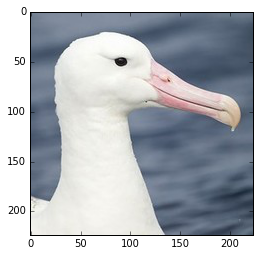

top-5 classes are:
0.999703	albatross
0.000295	goose
0.000001	ptarmigan
0.000001	drake
0.000000	pelican


In [278]:
img = imread('sample_images/albatross.jpg')
plt.imshow(img)
plt.show()

p = prob(preprocess(img))

labels = p.ravel().argsort()[-1:-6:-1]
print 'top-5 classes are:'
for l in labels:
    print '%3f\t%s' % (p.ravel()[l], classes[l].split(',')[0])

# Grand-quest: Dogs Vs Cats
* original competition
* https://www.kaggle.com/c/dogs-vs-cats
* 25k JPEG images of various size, 2 classes (guess what)

### Your main objective
* In this seminar your goal is to fine-tune a pre-trained model to distinguish between the two rivaling animals
* The first step is to just reuse some network layer as features

In [121]:
!wget https://www.dropbox.com/s/d61lupw909hc785/dogs_vs_cats.train.zip?dl=1 -O data.zip
!unzip data.zip

--2017-05-25 18:12:07--  https://www.dropbox.com/s/d61lupw909hc785/dogs_vs_cats.train.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.66.1
Connecting to www.dropbox.com (www.dropbox.com)|162.125.66.1|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://dl.dropboxusercontent.com/content_link/jP3VUtq7rw6iouOGknDbSfEV5ZpAZ7CN48fxBCLX0Sofqva7ZGd3aqIl3oZIfiob/file?dl=1 [following]
--2017-05-25 18:12:07--  https://dl.dropboxusercontent.com/content_link/jP3VUtq7rw6iouOGknDbSfEV5ZpAZ7CN48fxBCLX0Sofqva7ZGd3aqIl3oZIfiob/file?dl=1
Resolving dl.dropboxusercontent.com (dl.dropboxusercontent.com)... 162.125.82.6
Connecting to dl.dropboxusercontent.com (dl.dropboxusercontent.com)|162.125.82.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 569546721 (543M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>] 543.16M  5.13MB/s    in 2m 2s   

2017-05-25 18:14:12 (4.44 MB/s) - ‘data.zip’ saved

  inflating: train/cat.10381.jpg     
  inflating: train/cat.10382.jpg     
  inflating: train/cat.10383.jpg     
  inflating: train/cat.10384.jpg     
  inflating: train/cat.10385.jpg     
  inflating: train/cat.10386.jpg     
  inflating: train/cat.10387.jpg     
  inflating: train/cat.10388.jpg     
  inflating: train/cat.10389.jpg     
  inflating: train/cat.1039.jpg      
  inflating: train/cat.10390.jpg     
  inflating: train/cat.10391.jpg     
  inflating: train/cat.10392.jpg     
  inflating: train/cat.10393.jpg     
  inflating: train/cat.10394.jpg     
  inflating: train/cat.10395.jpg     
  inflating: train/cat.10396.jpg     
  inflating: train/cat.10397.jpg     
  inflating: train/cat.10398.jpg     
  inflating: train/cat.10399.jpg     
  inflating: train/cat.104.jpg       
  inflating: train/cat.1040.jpg      
  inflating: train/cat.10400.jpg     
  inflating: train/cat.10401.jpg     
  inflating: train/cat.10402.jpg     
  inflating: train/cat.10403.jpg     
  inflating:

  inflating: train/cat.10685.jpg     
  inflating: train/cat.10686.jpg     
  inflating: train/cat.10687.jpg     
  inflating: train/cat.10688.jpg     
  inflating: train/cat.10689.jpg     
  inflating: train/cat.1069.jpg      
  inflating: train/cat.10690.jpg     
  inflating: train/cat.10691.jpg     
  inflating: train/cat.10692.jpg     
  inflating: train/cat.10693.jpg     
  inflating: train/cat.10694.jpg     
  inflating: train/cat.10695.jpg     
  inflating: train/cat.10696.jpg     
  inflating: train/cat.10697.jpg     
  inflating: train/cat.10698.jpg     
  inflating: train/cat.10699.jpg     
  inflating: train/cat.107.jpg       
  inflating: train/cat.1070.jpg      
  inflating: train/cat.10700.jpg     
  inflating: train/cat.10701.jpg     
  inflating: train/cat.10702.jpg     
  inflating: train/cat.10703.jpg     
  inflating: train/cat.10704.jpg     
  inflating: train/cat.10705.jpg     
  inflating: train/cat.10706.jpg     
  inflating: train/cat.10707.jpg     
  inflating:

  inflating: train/cat.10985.jpg     
  inflating: train/cat.10986.jpg     
  inflating: train/cat.10987.jpg     
  inflating: train/cat.10988.jpg     
  inflating: train/cat.10989.jpg     
  inflating: train/cat.1099.jpg      
  inflating: train/cat.10990.jpg     
  inflating: train/cat.10991.jpg     
  inflating: train/cat.10992.jpg     
  inflating: train/cat.10993.jpg     
  inflating: train/cat.10994.jpg     
  inflating: train/cat.10995.jpg     
  inflating: train/cat.10996.jpg     
  inflating: train/cat.10997.jpg     
  inflating: train/cat.10998.jpg     
  inflating: train/cat.10999.jpg     
  inflating: train/cat.11.jpg        
  inflating: train/cat.110.jpg       
  inflating: train/cat.1100.jpg      
  inflating: train/cat.11000.jpg     
  inflating: train/cat.11001.jpg     
  inflating: train/cat.11002.jpg     
  inflating: train/cat.11003.jpg     
  inflating: train/cat.11004.jpg     
  inflating: train/cat.11005.jpg     
  inflating: train/cat.11006.jpg     
  inflating:

  inflating: train/cat.11311.jpg     
  inflating: train/cat.11312.jpg     
  inflating: train/cat.11313.jpg     
  inflating: train/cat.11314.jpg     
  inflating: train/cat.11315.jpg     
  inflating: train/cat.11316.jpg     
  inflating: train/cat.11317.jpg     
  inflating: train/cat.11318.jpg     
  inflating: train/cat.11319.jpg     
  inflating: train/cat.1132.jpg      
  inflating: train/cat.11320.jpg     
  inflating: train/cat.11321.jpg     
  inflating: train/cat.11322.jpg     
  inflating: train/cat.11323.jpg     
  inflating: train/cat.11324.jpg     
  inflating: train/cat.11325.jpg     
  inflating: train/cat.11326.jpg     
  inflating: train/cat.11327.jpg     
  inflating: train/cat.11328.jpg     
  inflating: train/cat.11329.jpg     
  inflating: train/cat.1133.jpg      
  inflating: train/cat.11330.jpg     
  inflating: train/cat.11331.jpg     
  inflating: train/cat.11332.jpg     
  inflating: train/cat.11333.jpg     
  inflating: train/cat.11334.jpg     
  inflating:

  inflating: train/cat.11627.jpg     
  inflating: train/cat.11628.jpg     
  inflating: train/cat.11629.jpg     
  inflating: train/cat.1163.jpg      
  inflating: train/cat.11630.jpg     
  inflating: train/cat.11631.jpg     
  inflating: train/cat.11632.jpg     
  inflating: train/cat.11633.jpg     
  inflating: train/cat.11634.jpg     
  inflating: train/cat.11635.jpg     
  inflating: train/cat.11636.jpg     
  inflating: train/cat.11637.jpg     
  inflating: train/cat.11638.jpg     
  inflating: train/cat.11639.jpg     
  inflating: train/cat.1164.jpg      
  inflating: train/cat.11640.jpg     
  inflating: train/cat.11641.jpg     
  inflating: train/cat.11642.jpg     
  inflating: train/cat.11643.jpg     
  inflating: train/cat.11644.jpg     
  inflating: train/cat.11645.jpg     
  inflating: train/cat.11646.jpg     
  inflating: train/cat.11647.jpg     
  inflating: train/cat.11648.jpg     
  inflating: train/cat.11649.jpg     
  inflating: train/cat.1165.jpg      
  inflating:

  inflating: train/cat.11937.jpg     
  inflating: train/cat.11938.jpg     
  inflating: train/cat.11939.jpg     
  inflating: train/cat.1194.jpg      
  inflating: train/cat.11940.jpg     
  inflating: train/cat.11941.jpg     
  inflating: train/cat.11942.jpg     
  inflating: train/cat.11943.jpg     
  inflating: train/cat.11944.jpg     
  inflating: train/cat.11945.jpg     
  inflating: train/cat.11946.jpg     
  inflating: train/cat.11947.jpg     
  inflating: train/cat.11948.jpg     
  inflating: train/cat.11949.jpg     
  inflating: train/cat.1195.jpg      
  inflating: train/cat.11950.jpg     
  inflating: train/cat.11951.jpg     
  inflating: train/cat.11952.jpg     
  inflating: train/cat.11953.jpg     
  inflating: train/cat.11954.jpg     
  inflating: train/cat.11955.jpg     
  inflating: train/cat.11956.jpg     
  inflating: train/cat.11957.jpg     
  inflating: train/cat.11958.jpg     
  inflating: train/cat.11959.jpg     
  inflating: train/cat.1196.jpg      
  inflating:

  inflating: train/cat.12223.jpg     
  inflating: train/cat.12224.jpg     
  inflating: train/cat.12225.jpg     
  inflating: train/cat.12226.jpg     
  inflating: train/cat.12227.jpg     
  inflating: train/cat.12228.jpg     
  inflating: train/cat.12229.jpg     
  inflating: train/cat.1223.jpg      
  inflating: train/cat.12230.jpg     
  inflating: train/cat.12231.jpg     
  inflating: train/cat.12232.jpg     
  inflating: train/cat.12233.jpg     
  inflating: train/cat.12234.jpg     
  inflating: train/cat.12235.jpg     
  inflating: train/cat.12236.jpg     
  inflating: train/cat.12237.jpg     
  inflating: train/cat.12238.jpg     
  inflating: train/cat.12239.jpg     
  inflating: train/cat.1224.jpg      
  inflating: train/cat.12240.jpg     
  inflating: train/cat.12241.jpg     
  inflating: train/cat.12242.jpg     
  inflating: train/cat.12243.jpg     
  inflating: train/cat.12244.jpg     
  inflating: train/cat.12245.jpg     
  inflating: train/cat.12246.jpg     
  inflating:

  inflating: train/cat.1288.jpg      
  inflating: train/cat.1289.jpg      
  inflating: train/cat.129.jpg       
  inflating: train/cat.1290.jpg      
  inflating: train/cat.1291.jpg      
  inflating: train/cat.1292.jpg      
  inflating: train/cat.1293.jpg      
  inflating: train/cat.1294.jpg      
  inflating: train/cat.1295.jpg      
  inflating: train/cat.1296.jpg      
  inflating: train/cat.1297.jpg      
  inflating: train/cat.1298.jpg      
  inflating: train/cat.1299.jpg      
  inflating: train/cat.13.jpg        
  inflating: train/cat.130.jpg       
  inflating: train/cat.1300.jpg      
  inflating: train/cat.1301.jpg      
  inflating: train/cat.1302.jpg      
  inflating: train/cat.1303.jpg      
  inflating: train/cat.1304.jpg      
  inflating: train/cat.1305.jpg      
  inflating: train/cat.1306.jpg      
  inflating: train/cat.1307.jpg      
  inflating: train/cat.1308.jpg      
  inflating: train/cat.1309.jpg      
  inflating: train/cat.131.jpg       
  inflating:

  inflating: train/cat.1600.jpg      
  inflating: train/cat.1601.jpg      
  inflating: train/cat.1602.jpg      
  inflating: train/cat.1603.jpg      
  inflating: train/cat.1604.jpg      
  inflating: train/cat.1605.jpg      
  inflating: train/cat.1606.jpg      
  inflating: train/cat.1607.jpg      
  inflating: train/cat.1608.jpg      
  inflating: train/cat.1609.jpg      
  inflating: train/cat.161.jpg       
  inflating: train/cat.1610.jpg      
  inflating: train/cat.1611.jpg      
  inflating: train/cat.1612.jpg      
  inflating: train/cat.1613.jpg      
  inflating: train/cat.1614.jpg      
  inflating: train/cat.1615.jpg      
  inflating: train/cat.1616.jpg      
  inflating: train/cat.1617.jpg      
  inflating: train/cat.1618.jpg      
  inflating: train/cat.1619.jpg      
  inflating: train/cat.162.jpg       
  inflating: train/cat.1620.jpg      
  inflating: train/cat.1621.jpg      
  inflating: train/cat.1622.jpg      
  inflating: train/cat.1623.jpg      
  inflating:

  inflating: train/cat.1919.jpg      
  inflating: train/cat.192.jpg       
  inflating: train/cat.1920.jpg      
  inflating: train/cat.1921.jpg      
  inflating: train/cat.1922.jpg      
  inflating: train/cat.1923.jpg      
  inflating: train/cat.1924.jpg      
  inflating: train/cat.1925.jpg      
  inflating: train/cat.1926.jpg      
  inflating: train/cat.1927.jpg      
  inflating: train/cat.1928.jpg      
  inflating: train/cat.1929.jpg      
  inflating: train/cat.193.jpg       
  inflating: train/cat.1930.jpg      
  inflating: train/cat.1931.jpg      
  inflating: train/cat.1932.jpg      
  inflating: train/cat.1933.jpg      
  inflating: train/cat.1934.jpg      
  inflating: train/cat.1935.jpg      
  inflating: train/cat.1936.jpg      
  inflating: train/cat.1937.jpg      
  inflating: train/cat.1938.jpg      
  inflating: train/cat.1939.jpg      
  inflating: train/cat.194.jpg       
  inflating: train/cat.1940.jpg      
  inflating: train/cat.1941.jpg      
  inflating:

  inflating: train/cat.2229.jpg      
  inflating: train/cat.223.jpg       
  inflating: train/cat.2230.jpg      
  inflating: train/cat.2231.jpg      
  inflating: train/cat.2232.jpg      
  inflating: train/cat.2233.jpg      
  inflating: train/cat.2234.jpg      
  inflating: train/cat.2235.jpg      
  inflating: train/cat.2236.jpg      
  inflating: train/cat.2237.jpg      
  inflating: train/cat.2238.jpg      
  inflating: train/cat.2239.jpg      
  inflating: train/cat.224.jpg       
  inflating: train/cat.2240.jpg      
  inflating: train/cat.2241.jpg      
  inflating: train/cat.2242.jpg      
  inflating: train/cat.2243.jpg      
  inflating: train/cat.2244.jpg      
  inflating: train/cat.2245.jpg      
  inflating: train/cat.2246.jpg      
  inflating: train/cat.2247.jpg      
  inflating: train/cat.2248.jpg      
  inflating: train/cat.2249.jpg      
  inflating: train/cat.225.jpg       
  inflating: train/cat.2250.jpg      
  inflating: train/cat.2251.jpg      
  inflating:

  inflating: train/cat.2549.jpg      
  inflating: train/cat.255.jpg       
  inflating: train/cat.2550.jpg      
  inflating: train/cat.2551.jpg      
  inflating: train/cat.2552.jpg      
  inflating: train/cat.2553.jpg      
  inflating: train/cat.2554.jpg      
  inflating: train/cat.2555.jpg      
  inflating: train/cat.2556.jpg      
  inflating: train/cat.2557.jpg      
  inflating: train/cat.2558.jpg      
  inflating: train/cat.2559.jpg      
  inflating: train/cat.256.jpg       
  inflating: train/cat.2560.jpg      
  inflating: train/cat.2561.jpg      
  inflating: train/cat.2562.jpg      
  inflating: train/cat.2563.jpg      
  inflating: train/cat.2564.jpg      
  inflating: train/cat.2565.jpg      
  inflating: train/cat.2566.jpg      
  inflating: train/cat.2567.jpg      
  inflating: train/cat.2568.jpg      
  inflating: train/cat.2569.jpg      
  inflating: train/cat.257.jpg       
  inflating: train/cat.2570.jpg      
  inflating: train/cat.2571.jpg      
  inflating:

  inflating: train/cat.2854.jpg      
  inflating: train/cat.2855.jpg      
  inflating: train/cat.2856.jpg      
  inflating: train/cat.2857.jpg      
  inflating: train/cat.2858.jpg      
  inflating: train/cat.2859.jpg      
  inflating: train/cat.286.jpg       
  inflating: train/cat.2860.jpg      
  inflating: train/cat.2861.jpg      
  inflating: train/cat.2862.jpg      
  inflating: train/cat.2863.jpg      
  inflating: train/cat.2864.jpg      
  inflating: train/cat.2865.jpg      
  inflating: train/cat.2866.jpg      
  inflating: train/cat.2867.jpg      
  inflating: train/cat.2868.jpg      
  inflating: train/cat.2869.jpg      
  inflating: train/cat.287.jpg       
  inflating: train/cat.2870.jpg      
  inflating: train/cat.2871.jpg      
  inflating: train/cat.2872.jpg      
  inflating: train/cat.2873.jpg      
  inflating: train/cat.2874.jpg      
  inflating: train/cat.2875.jpg      
  inflating: train/cat.2876.jpg      
  inflating: train/cat.2877.jpg      
  inflating:

  inflating: train/cat.315.jpg       
  inflating: train/cat.3150.jpg      
  inflating: train/cat.3151.jpg      
  inflating: train/cat.3152.jpg      
  inflating: train/cat.3153.jpg      
  inflating: train/cat.3154.jpg      
  inflating: train/cat.3155.jpg      
  inflating: train/cat.3156.jpg      
  inflating: train/cat.3157.jpg      
  inflating: train/cat.3158.jpg      
  inflating: train/cat.3159.jpg      
  inflating: train/cat.316.jpg       
  inflating: train/cat.3160.jpg      
  inflating: train/cat.3161.jpg      
  inflating: train/cat.3162.jpg      
  inflating: train/cat.3163.jpg      
  inflating: train/cat.3164.jpg      
  inflating: train/cat.3165.jpg      
  inflating: train/cat.3166.jpg      
  inflating: train/cat.3167.jpg      
  inflating: train/cat.3168.jpg      
  inflating: train/cat.3169.jpg      
  inflating: train/cat.317.jpg       
  inflating: train/cat.3170.jpg      
  inflating: train/cat.3171.jpg      
  inflating: train/cat.3172.jpg      
  inflating:

  inflating: train/cat.3488.jpg      
  inflating: train/cat.3489.jpg      
  inflating: train/cat.349.jpg       
  inflating: train/cat.3490.jpg      
  inflating: train/cat.3491.jpg      
  inflating: train/cat.3492.jpg      
  inflating: train/cat.3493.jpg      
  inflating: train/cat.3494.jpg      
  inflating: train/cat.3495.jpg      
  inflating: train/cat.3496.jpg      
  inflating: train/cat.3497.jpg      
  inflating: train/cat.3498.jpg      
  inflating: train/cat.3499.jpg      
  inflating: train/cat.35.jpg        
  inflating: train/cat.350.jpg       
  inflating: train/cat.3500.jpg      
  inflating: train/cat.3501.jpg      
  inflating: train/cat.3502.jpg      
  inflating: train/cat.3503.jpg      
  inflating: train/cat.3504.jpg      
  inflating: train/cat.3505.jpg      
  inflating: train/cat.3506.jpg      
  inflating: train/cat.3507.jpg      
  inflating: train/cat.3508.jpg      
  inflating: train/cat.3509.jpg      
  inflating: train/cat.351.jpg       
  inflating:

  inflating: train/cat.3799.jpg      
  inflating: train/cat.38.jpg        
  inflating: train/cat.380.jpg       
  inflating: train/cat.3800.jpg      
  inflating: train/cat.3801.jpg      
  inflating: train/cat.3802.jpg      
  inflating: train/cat.3803.jpg      
  inflating: train/cat.3804.jpg      
  inflating: train/cat.3805.jpg      
  inflating: train/cat.3806.jpg      
  inflating: train/cat.3807.jpg      
  inflating: train/cat.3808.jpg      
  inflating: train/cat.3809.jpg      
  inflating: train/cat.381.jpg       
  inflating: train/cat.3810.jpg      
  inflating: train/cat.3811.jpg      
  inflating: train/cat.3812.jpg      
  inflating: train/cat.3813.jpg      
  inflating: train/cat.3814.jpg      
  inflating: train/cat.3815.jpg      
  inflating: train/cat.3816.jpg      
  inflating: train/cat.3817.jpg      
  inflating: train/cat.3818.jpg      
  inflating: train/cat.3819.jpg      
  inflating: train/cat.382.jpg       
  inflating: train/cat.3820.jpg      
  inflating:

  inflating: train/cat.4101.jpg      
  inflating: train/cat.4102.jpg      
  inflating: train/cat.4103.jpg      
  inflating: train/cat.4104.jpg      
  inflating: train/cat.4105.jpg      
  inflating: train/cat.4106.jpg      
  inflating: train/cat.4107.jpg      
  inflating: train/cat.4108.jpg      
  inflating: train/cat.4109.jpg      
  inflating: train/cat.411.jpg       
  inflating: train/cat.4110.jpg      
  inflating: train/cat.4111.jpg      
  inflating: train/cat.4112.jpg      
  inflating: train/cat.4113.jpg      
  inflating: train/cat.4114.jpg      
  inflating: train/cat.4115.jpg      
  inflating: train/cat.4116.jpg      
  inflating: train/cat.4117.jpg      
  inflating: train/cat.4118.jpg      
  inflating: train/cat.4119.jpg      
  inflating: train/cat.412.jpg       
  inflating: train/cat.4120.jpg      
  inflating: train/cat.4121.jpg      
  inflating: train/cat.4122.jpg      
  inflating: train/cat.4123.jpg      
  inflating: train/cat.4124.jpg      
  inflating:

  inflating: train/cat.4394.jpg      
  inflating: train/cat.4395.jpg      
  inflating: train/cat.4396.jpg      
  inflating: train/cat.4397.jpg      
  inflating: train/cat.4398.jpg      
  inflating: train/cat.4399.jpg      
  inflating: train/cat.44.jpg        
  inflating: train/cat.440.jpg       
  inflating: train/cat.4400.jpg      
  inflating: train/cat.4401.jpg      
  inflating: train/cat.4402.jpg      
  inflating: train/cat.4403.jpg      
  inflating: train/cat.4404.jpg      
  inflating: train/cat.4405.jpg      
  inflating: train/cat.4406.jpg      
  inflating: train/cat.4407.jpg      
  inflating: train/cat.4408.jpg      
  inflating: train/cat.4409.jpg      
  inflating: train/cat.441.jpg       
  inflating: train/cat.4410.jpg      
  inflating: train/cat.4411.jpg      
  inflating: train/cat.4412.jpg      
  inflating: train/cat.4413.jpg      
  inflating: train/cat.4414.jpg      
  inflating: train/cat.4415.jpg      
  inflating: train/cat.4416.jpg      
  inflating:

  inflating: train/cat.4704.jpg      
  inflating: train/cat.4705.jpg      
  inflating: train/cat.4706.jpg      
  inflating: train/cat.4707.jpg      
  inflating: train/cat.4708.jpg      
  inflating: train/cat.4709.jpg      
  inflating: train/cat.471.jpg       
  inflating: train/cat.4710.jpg      
  inflating: train/cat.4711.jpg      
  inflating: train/cat.4712.jpg      
  inflating: train/cat.4713.jpg      
  inflating: train/cat.4714.jpg      
  inflating: train/cat.4715.jpg      
  inflating: train/cat.4716.jpg      
  inflating: train/cat.4717.jpg      
  inflating: train/cat.4718.jpg      
  inflating: train/cat.4719.jpg      
  inflating: train/cat.472.jpg       
  inflating: train/cat.4720.jpg      
  inflating: train/cat.4721.jpg      
  inflating: train/cat.4722.jpg      
  inflating: train/cat.4723.jpg      
  inflating: train/cat.4724.jpg      
  inflating: train/cat.4725.jpg      
  inflating: train/cat.4726.jpg      
  inflating: train/cat.4727.jpg      
  inflating:

  inflating: train/cat.5016.jpg      
  inflating: train/cat.5017.jpg      
  inflating: train/cat.5018.jpg      
  inflating: train/cat.5019.jpg      
  inflating: train/cat.502.jpg       
  inflating: train/cat.5020.jpg      
  inflating: train/cat.5021.jpg      
  inflating: train/cat.5022.jpg      
  inflating: train/cat.5023.jpg      
  inflating: train/cat.5024.jpg      
  inflating: train/cat.5025.jpg      
  inflating: train/cat.5026.jpg      
  inflating: train/cat.5027.jpg      
  inflating: train/cat.5028.jpg      
  inflating: train/cat.5029.jpg      
  inflating: train/cat.503.jpg       
  inflating: train/cat.5030.jpg      
  inflating: train/cat.5031.jpg      
  inflating: train/cat.5032.jpg      
  inflating: train/cat.5033.jpg      
  inflating: train/cat.5034.jpg      
  inflating: train/cat.5035.jpg      
  inflating: train/cat.5036.jpg      
  inflating: train/cat.5037.jpg      
  inflating: train/cat.5038.jpg      
  inflating: train/cat.5039.jpg      
  inflating:

  inflating: train/cat.5322.jpg      
  inflating: train/cat.5323.jpg      
  inflating: train/cat.5324.jpg      
  inflating: train/cat.5325.jpg      
  inflating: train/cat.5326.jpg      
  inflating: train/cat.5327.jpg      
  inflating: train/cat.5328.jpg      
  inflating: train/cat.5329.jpg      
  inflating: train/cat.533.jpg       
  inflating: train/cat.5330.jpg      
  inflating: train/cat.5331.jpg      
  inflating: train/cat.5332.jpg      
  inflating: train/cat.5333.jpg      
  inflating: train/cat.5334.jpg      
  inflating: train/cat.5335.jpg      
  inflating: train/cat.5336.jpg      
  inflating: train/cat.5337.jpg      
  inflating: train/cat.5338.jpg      
  inflating: train/cat.5339.jpg      
  inflating: train/cat.534.jpg       
  inflating: train/cat.5340.jpg      
  inflating: train/cat.5341.jpg      
  inflating: train/cat.5342.jpg      
  inflating: train/cat.5343.jpg      
  inflating: train/cat.5344.jpg      
  inflating: train/cat.5345.jpg      
  inflating:

  inflating: train/cat.5613.jpg      
  inflating: train/cat.5614.jpg      
  inflating: train/cat.5615.jpg      
  inflating: train/cat.5616.jpg      
  inflating: train/cat.5617.jpg      
  inflating: train/cat.5618.jpg      
  inflating: train/cat.5619.jpg      
  inflating: train/cat.562.jpg       
  inflating: train/cat.5620.jpg      
  inflating: train/cat.5621.jpg      
  inflating: train/cat.5622.jpg      
  inflating: train/cat.5623.jpg      
  inflating: train/cat.5624.jpg      
  inflating: train/cat.5625.jpg      
  inflating: train/cat.5626.jpg      
  inflating: train/cat.5627.jpg      
  inflating: train/cat.5628.jpg      
  inflating: train/cat.5629.jpg      
  inflating: train/cat.563.jpg       
  inflating: train/cat.5630.jpg      
  inflating: train/cat.5631.jpg      
  inflating: train/cat.5632.jpg      
  inflating: train/cat.5633.jpg      
  inflating: train/cat.5634.jpg      
  inflating: train/cat.5635.jpg      
  inflating: train/cat.5636.jpg      
  inflating:

  inflating: train/cat.5924.jpg      
  inflating: train/cat.5925.jpg      
  inflating: train/cat.5926.jpg      
  inflating: train/cat.5927.jpg      
  inflating: train/cat.5928.jpg      
  inflating: train/cat.5929.jpg      
  inflating: train/cat.593.jpg       
  inflating: train/cat.5930.jpg      
  inflating: train/cat.5931.jpg      
  inflating: train/cat.5932.jpg      
  inflating: train/cat.5933.jpg      
  inflating: train/cat.5934.jpg      
  inflating: train/cat.5935.jpg      
  inflating: train/cat.5936.jpg      
  inflating: train/cat.5937.jpg      
  inflating: train/cat.5938.jpg      
  inflating: train/cat.5939.jpg      
  inflating: train/cat.594.jpg       
  inflating: train/cat.5940.jpg      
  inflating: train/cat.5941.jpg      
  inflating: train/cat.5942.jpg      
  inflating: train/cat.5943.jpg      
  inflating: train/cat.5944.jpg      
  inflating: train/cat.5945.jpg      
  inflating: train/cat.5946.jpg      
  inflating: train/cat.5947.jpg      
  inflating:

  inflating: train/cat.6224.jpg      
  inflating: train/cat.6225.jpg      
  inflating: train/cat.6226.jpg      
  inflating: train/cat.6227.jpg      
  inflating: train/cat.6228.jpg      
  inflating: train/cat.6229.jpg      
  inflating: train/cat.623.jpg       
  inflating: train/cat.6230.jpg      
  inflating: train/cat.6231.jpg      
  inflating: train/cat.6232.jpg      
  inflating: train/cat.6233.jpg      
  inflating: train/cat.6234.jpg      
  inflating: train/cat.6235.jpg      
  inflating: train/cat.6236.jpg      
  inflating: train/cat.6237.jpg      
  inflating: train/cat.6238.jpg      
  inflating: train/cat.6239.jpg      
  inflating: train/cat.624.jpg       
  inflating: train/cat.6240.jpg      
  inflating: train/cat.6241.jpg      
  inflating: train/cat.6242.jpg      
  inflating: train/cat.6243.jpg      
  inflating: train/cat.6244.jpg      
  inflating: train/cat.6245.jpg      
  inflating: train/cat.6246.jpg      
  inflating: train/cat.6247.jpg      
  inflating:

  inflating: train/cat.6522.jpg      
  inflating: train/cat.6523.jpg      
  inflating: train/cat.6524.jpg      
  inflating: train/cat.6525.jpg      
  inflating: train/cat.6526.jpg      
  inflating: train/cat.6527.jpg      
  inflating: train/cat.6528.jpg      
  inflating: train/cat.6529.jpg      
  inflating: train/cat.653.jpg       
  inflating: train/cat.6530.jpg      
  inflating: train/cat.6531.jpg      
  inflating: train/cat.6532.jpg      
  inflating: train/cat.6533.jpg      
  inflating: train/cat.6534.jpg      
  inflating: train/cat.6535.jpg      
  inflating: train/cat.6536.jpg      
  inflating: train/cat.6537.jpg      
  inflating: train/cat.6538.jpg      
  inflating: train/cat.6539.jpg      
  inflating: train/cat.654.jpg       
  inflating: train/cat.6540.jpg      
  inflating: train/cat.6541.jpg      
  inflating: train/cat.6542.jpg      
  inflating: train/cat.6543.jpg      
  inflating: train/cat.6544.jpg      
  inflating: train/cat.6545.jpg      
  inflating:

  inflating: train/cat.683.jpg       
  inflating: train/cat.6830.jpg      
  inflating: train/cat.6831.jpg      
  inflating: train/cat.6832.jpg      
  inflating: train/cat.6833.jpg      
  inflating: train/cat.6834.jpg      
  inflating: train/cat.6835.jpg      
  inflating: train/cat.6836.jpg      
  inflating: train/cat.6837.jpg      
  inflating: train/cat.6838.jpg      
  inflating: train/cat.6839.jpg      
  inflating: train/cat.684.jpg       
  inflating: train/cat.6840.jpg      
  inflating: train/cat.6841.jpg      
  inflating: train/cat.6842.jpg      
  inflating: train/cat.6843.jpg      
  inflating: train/cat.6844.jpg      
  inflating: train/cat.6845.jpg      
  inflating: train/cat.6846.jpg      
  inflating: train/cat.6847.jpg      
  inflating: train/cat.6848.jpg      
  inflating: train/cat.6849.jpg      
  inflating: train/cat.685.jpg       
  inflating: train/cat.6850.jpg      
  inflating: train/cat.6851.jpg      
  inflating: train/cat.6852.jpg      
  inflating:

  inflating: train/cat.7134.jpg      
  inflating: train/cat.7135.jpg      
  inflating: train/cat.7136.jpg      
  inflating: train/cat.7137.jpg      
  inflating: train/cat.7138.jpg      
  inflating: train/cat.7139.jpg      
  inflating: train/cat.714.jpg       
  inflating: train/cat.7140.jpg      
  inflating: train/cat.7141.jpg      
  inflating: train/cat.7142.jpg      
  inflating: train/cat.7143.jpg      
  inflating: train/cat.7144.jpg      
  inflating: train/cat.7145.jpg      
  inflating: train/cat.7146.jpg      
  inflating: train/cat.7147.jpg      
  inflating: train/cat.7148.jpg      
  inflating: train/cat.7149.jpg      
  inflating: train/cat.715.jpg       
  inflating: train/cat.7150.jpg      
  inflating: train/cat.7151.jpg      
  inflating: train/cat.7152.jpg      
  inflating: train/cat.7153.jpg      
  inflating: train/cat.7154.jpg      
  inflating: train/cat.7155.jpg      
  inflating: train/cat.7156.jpg      
  inflating: train/cat.7157.jpg      
  inflating:

  inflating: train/cat.7450.jpg      
  inflating: train/cat.7451.jpg      
  inflating: train/cat.7452.jpg      
  inflating: train/cat.7453.jpg      
  inflating: train/cat.7454.jpg      
  inflating: train/cat.7455.jpg      
  inflating: train/cat.7456.jpg      
  inflating: train/cat.7457.jpg      
  inflating: train/cat.7458.jpg      
  inflating: train/cat.7459.jpg      
  inflating: train/cat.746.jpg       
  inflating: train/cat.7460.jpg      
  inflating: train/cat.7461.jpg      
  inflating: train/cat.7462.jpg      
  inflating: train/cat.7463.jpg      
  inflating: train/cat.7464.jpg      
  inflating: train/cat.7465.jpg      
  inflating: train/cat.7466.jpg      
  inflating: train/cat.7467.jpg      
  inflating: train/cat.7468.jpg      
  inflating: train/cat.7469.jpg      
  inflating: train/cat.747.jpg       
  inflating: train/cat.7470.jpg      
  inflating: train/cat.7471.jpg      
  inflating: train/cat.7472.jpg      
  inflating: train/cat.7473.jpg      
  inflating:

  inflating: train/cat.7761.jpg      
  inflating: train/cat.7762.jpg      
  inflating: train/cat.7763.jpg      
  inflating: train/cat.7764.jpg      
  inflating: train/cat.7765.jpg      
  inflating: train/cat.7766.jpg      
  inflating: train/cat.7767.jpg      
  inflating: train/cat.7768.jpg      
  inflating: train/cat.7769.jpg      
  inflating: train/cat.777.jpg       
  inflating: train/cat.7770.jpg      
  inflating: train/cat.7771.jpg      
  inflating: train/cat.7772.jpg      
  inflating: train/cat.7773.jpg      
  inflating: train/cat.7774.jpg      
  inflating: train/cat.7775.jpg      
  inflating: train/cat.7776.jpg      
  inflating: train/cat.7777.jpg      
  inflating: train/cat.7778.jpg      
  inflating: train/cat.7779.jpg      
  inflating: train/cat.778.jpg       
  inflating: train/cat.7780.jpg      
  inflating: train/cat.7781.jpg      
  inflating: train/cat.7782.jpg      
  inflating: train/cat.7783.jpg      
  inflating: train/cat.7784.jpg      
  inflating:

  inflating: train/cat.807.jpg       
  inflating: train/cat.8070.jpg      
  inflating: train/cat.8071.jpg      
  inflating: train/cat.8072.jpg      
  inflating: train/cat.8073.jpg      
  inflating: train/cat.8074.jpg      
  inflating: train/cat.8075.jpg      
  inflating: train/cat.8076.jpg      
  inflating: train/cat.8077.jpg      
  inflating: train/cat.8078.jpg      
  inflating: train/cat.8079.jpg      
  inflating: train/cat.808.jpg       
  inflating: train/cat.8080.jpg      
  inflating: train/cat.8081.jpg      
  inflating: train/cat.8082.jpg      
  inflating: train/cat.8083.jpg      
  inflating: train/cat.8084.jpg      
  inflating: train/cat.8085.jpg      
  inflating: train/cat.8086.jpg      
  inflating: train/cat.8087.jpg      
  inflating: train/cat.8088.jpg      
  inflating: train/cat.8089.jpg      
  inflating: train/cat.809.jpg       
  inflating: train/cat.8090.jpg      
  inflating: train/cat.8091.jpg      
  inflating: train/cat.8092.jpg      
  inflating:

  inflating: train/cat.8368.jpg      
  inflating: train/cat.8369.jpg      
  inflating: train/cat.837.jpg       
  inflating: train/cat.8370.jpg      
  inflating: train/cat.8371.jpg      
  inflating: train/cat.8372.jpg      
  inflating: train/cat.8373.jpg      
  inflating: train/cat.8374.jpg      
  inflating: train/cat.8375.jpg      
  inflating: train/cat.8376.jpg      
  inflating: train/cat.8377.jpg      
  inflating: train/cat.8378.jpg      
  inflating: train/cat.8379.jpg      
  inflating: train/cat.838.jpg       
  inflating: train/cat.8380.jpg      
  inflating: train/cat.8381.jpg      
  inflating: train/cat.8382.jpg      
  inflating: train/cat.8383.jpg      
  inflating: train/cat.8384.jpg      
  inflating: train/cat.8385.jpg      
  inflating: train/cat.8386.jpg      
  inflating: train/cat.8387.jpg      
  inflating: train/cat.8388.jpg      
  inflating: train/cat.8389.jpg      
  inflating: train/cat.839.jpg       
  inflating: train/cat.8390.jpg      
  inflating:

  inflating: train/cat.8674.jpg      
  inflating: train/cat.8675.jpg      
  inflating: train/cat.8676.jpg      
  inflating: train/cat.8677.jpg      
  inflating: train/cat.8678.jpg      
  inflating: train/cat.8679.jpg      
  inflating: train/cat.868.jpg       
  inflating: train/cat.8680.jpg      
  inflating: train/cat.8681.jpg      
  inflating: train/cat.8682.jpg      
  inflating: train/cat.8683.jpg      
  inflating: train/cat.8684.jpg      
  inflating: train/cat.8685.jpg      
  inflating: train/cat.8686.jpg      
  inflating: train/cat.8687.jpg      
  inflating: train/cat.8688.jpg      
  inflating: train/cat.8689.jpg      
  inflating: train/cat.869.jpg       
  inflating: train/cat.8690.jpg      
  inflating: train/cat.8691.jpg      
  inflating: train/cat.8692.jpg      
  inflating: train/cat.8693.jpg      
  inflating: train/cat.8694.jpg      
  inflating: train/cat.8695.jpg      
  inflating: train/cat.8696.jpg      
  inflating: train/cat.8697.jpg      
  inflating:

  inflating: train/cat.8986.jpg      
  inflating: train/cat.8987.jpg      
  inflating: train/cat.8988.jpg      
  inflating: train/cat.8989.jpg      
  inflating: train/cat.899.jpg       
  inflating: train/cat.8990.jpg      
  inflating: train/cat.8991.jpg      
  inflating: train/cat.8992.jpg      
  inflating: train/cat.8993.jpg      
  inflating: train/cat.8994.jpg      
  inflating: train/cat.8995.jpg      
  inflating: train/cat.8996.jpg      
  inflating: train/cat.8997.jpg      
  inflating: train/cat.8998.jpg      
  inflating: train/cat.8999.jpg      
  inflating: train/cat.9.jpg         
  inflating: train/cat.90.jpg        
  inflating: train/cat.900.jpg       
  inflating: train/cat.9000.jpg      
  inflating: train/cat.9001.jpg      
  inflating: train/cat.9002.jpg      
  inflating: train/cat.9003.jpg      
  inflating: train/cat.9004.jpg      
  inflating: train/cat.9005.jpg      
  inflating: train/cat.9006.jpg      
  inflating: train/cat.9007.jpg      
  inflating:

  inflating: train/cat.930.jpg       
  inflating: train/cat.9300.jpg      
  inflating: train/cat.9301.jpg      
  inflating: train/cat.9302.jpg      
  inflating: train/cat.9303.jpg      
  inflating: train/cat.9304.jpg      
  inflating: train/cat.9305.jpg      
  inflating: train/cat.9306.jpg      
  inflating: train/cat.9307.jpg      
  inflating: train/cat.9308.jpg      
  inflating: train/cat.9309.jpg      
  inflating: train/cat.931.jpg       
  inflating: train/cat.9310.jpg      
  inflating: train/cat.9311.jpg      
  inflating: train/cat.9312.jpg      
  inflating: train/cat.9313.jpg      
  inflating: train/cat.9314.jpg      
  inflating: train/cat.9315.jpg      
  inflating: train/cat.9316.jpg      
  inflating: train/cat.9317.jpg      
  inflating: train/cat.9318.jpg      
  inflating: train/cat.9319.jpg      
  inflating: train/cat.932.jpg       
  inflating: train/cat.9320.jpg      
  inflating: train/cat.9321.jpg      
  inflating: train/cat.9322.jpg      
  inflating:

  inflating: train/cat.9614.jpg      
  inflating: train/cat.9615.jpg      
  inflating: train/cat.9616.jpg      
  inflating: train/cat.9617.jpg      
  inflating: train/cat.9618.jpg      
  inflating: train/cat.9619.jpg      
  inflating: train/cat.962.jpg       
  inflating: train/cat.9620.jpg      
  inflating: train/cat.9621.jpg      
  inflating: train/cat.9622.jpg      
  inflating: train/cat.9623.jpg      
  inflating: train/cat.9624.jpg      
  inflating: train/cat.9625.jpg      
  inflating: train/cat.9626.jpg      
  inflating: train/cat.9627.jpg      
  inflating: train/cat.9628.jpg      
  inflating: train/cat.9629.jpg      
  inflating: train/cat.963.jpg       
  inflating: train/cat.9630.jpg      
  inflating: train/cat.9631.jpg      
  inflating: train/cat.9632.jpg      
  inflating: train/cat.9633.jpg      
  inflating: train/cat.9634.jpg      
  inflating: train/cat.9635.jpg      
  inflating: train/cat.9636.jpg      
  inflating: train/cat.9637.jpg      
  inflating:

  inflating: train/cat.9917.jpg      
  inflating: train/cat.9918.jpg      
  inflating: train/cat.9919.jpg      
  inflating: train/cat.992.jpg       
  inflating: train/cat.9920.jpg      
  inflating: train/cat.9921.jpg      
  inflating: train/cat.9922.jpg      
  inflating: train/cat.9923.jpg      
  inflating: train/cat.9924.jpg      
  inflating: train/cat.9925.jpg      
  inflating: train/cat.9926.jpg      
  inflating: train/cat.9927.jpg      
  inflating: train/cat.9928.jpg      
  inflating: train/cat.9929.jpg      
  inflating: train/cat.993.jpg       
  inflating: train/cat.9930.jpg      
  inflating: train/cat.9931.jpg      
  inflating: train/cat.9932.jpg      
  inflating: train/cat.9933.jpg      
  inflating: train/cat.9934.jpg      
  inflating: train/cat.9935.jpg      
  inflating: train/cat.9936.jpg      
  inflating: train/cat.9937.jpg      
  inflating: train/cat.9938.jpg      
  inflating: train/cat.9939.jpg      
  inflating: train/cat.994.jpg       
  inflating:

  inflating: train/dog.10184.jpg     
  inflating: train/dog.10185.jpg     
  inflating: train/dog.10186.jpg     
  inflating: train/dog.10187.jpg     
  inflating: train/dog.10188.jpg     
  inflating: train/dog.10189.jpg     
  inflating: train/dog.1019.jpg      
  inflating: train/dog.10190.jpg     
  inflating: train/dog.10191.jpg     
  inflating: train/dog.10192.jpg     
  inflating: train/dog.10193.jpg     
  inflating: train/dog.10194.jpg     
  inflating: train/dog.10195.jpg     
  inflating: train/dog.10196.jpg     
  inflating: train/dog.10197.jpg     
  inflating: train/dog.10198.jpg     
  inflating: train/dog.10199.jpg     
  inflating: train/dog.102.jpg       
  inflating: train/dog.1020.jpg      
  inflating: train/dog.10200.jpg     
  inflating: train/dog.10201.jpg     
  inflating: train/dog.10202.jpg     
  inflating: train/dog.10203.jpg     
  inflating: train/dog.10204.jpg     
  inflating: train/dog.10205.jpg     
  inflating: train/dog.10206.jpg     
  inflating:

  inflating: train/dog.1046.jpg      
  inflating: train/dog.10460.jpg     
  inflating: train/dog.10461.jpg     
  inflating: train/dog.10462.jpg     
  inflating: train/dog.10463.jpg     
  inflating: train/dog.10464.jpg     
  inflating: train/dog.10465.jpg     
  inflating: train/dog.10466.jpg     
  inflating: train/dog.10467.jpg     
  inflating: train/dog.10468.jpg     
  inflating: train/dog.10469.jpg     
  inflating: train/dog.1047.jpg      
  inflating: train/dog.10470.jpg     
  inflating: train/dog.10471.jpg     
  inflating: train/dog.10472.jpg     
  inflating: train/dog.10473.jpg     
  inflating: train/dog.10474.jpg     
  inflating: train/dog.10475.jpg     
  inflating: train/dog.10476.jpg     
  inflating: train/dog.10477.jpg     
  inflating: train/dog.10478.jpg     
  inflating: train/dog.10479.jpg     
  inflating: train/dog.1048.jpg      
  inflating: train/dog.10480.jpg     
  inflating: train/dog.10481.jpg     
  inflating: train/dog.10482.jpg     
  inflating:

  inflating: train/dog.10718.jpg     
  inflating: train/dog.10719.jpg     
  inflating: train/dog.1072.jpg      
  inflating: train/dog.10720.jpg     
  inflating: train/dog.10721.jpg     
  inflating: train/dog.10722.jpg     
  inflating: train/dog.10723.jpg     
  inflating: train/dog.10724.jpg     
  inflating: train/dog.10725.jpg     
  inflating: train/dog.10726.jpg     
  inflating: train/dog.10727.jpg     
  inflating: train/dog.10728.jpg     
  inflating: train/dog.10729.jpg     
  inflating: train/dog.1073.jpg      
  inflating: train/dog.10730.jpg     
  inflating: train/dog.10731.jpg     
  inflating: train/dog.10732.jpg     
  inflating: train/dog.10733.jpg     
  inflating: train/dog.10734.jpg     
  inflating: train/dog.10735.jpg     
  inflating: train/dog.10736.jpg     
  inflating: train/dog.10737.jpg     
  inflating: train/dog.10738.jpg     
  inflating: train/dog.10739.jpg     
  inflating: train/dog.1074.jpg      
  inflating: train/dog.10740.jpg     
  inflating:

  inflating: train/dog.10987.jpg     
  inflating: train/dog.10988.jpg     
  inflating: train/dog.10989.jpg     
  inflating: train/dog.1099.jpg      
  inflating: train/dog.10990.jpg     
  inflating: train/dog.10991.jpg     
  inflating: train/dog.10992.jpg     
  inflating: train/dog.10993.jpg     
  inflating: train/dog.10994.jpg     
  inflating: train/dog.10995.jpg     
  inflating: train/dog.10996.jpg     
  inflating: train/dog.10997.jpg     
  inflating: train/dog.10998.jpg     
  inflating: train/dog.10999.jpg     
  inflating: train/dog.11.jpg        
  inflating: train/dog.110.jpg       
  inflating: train/dog.1100.jpg      
  inflating: train/dog.11000.jpg     
  inflating: train/dog.11001.jpg     
  inflating: train/dog.11002.jpg     
  inflating: train/dog.11003.jpg     
  inflating: train/dog.11004.jpg     
  inflating: train/dog.11005.jpg     
  inflating: train/dog.11006.jpg     
  inflating: train/dog.11007.jpg     
  inflating: train/dog.11008.jpg     
  inflating:

  inflating: train/dog.11264.jpg     
  inflating: train/dog.11265.jpg     
  inflating: train/dog.11266.jpg     
  inflating: train/dog.11267.jpg     
  inflating: train/dog.11268.jpg     
  inflating: train/dog.11269.jpg     
  inflating: train/dog.1127.jpg      
  inflating: train/dog.11270.jpg     
  inflating: train/dog.11271.jpg     
  inflating: train/dog.11272.jpg     
  inflating: train/dog.11273.jpg     
  inflating: train/dog.11274.jpg     
  inflating: train/dog.11275.jpg     
  inflating: train/dog.11276.jpg     
  inflating: train/dog.11277.jpg     
  inflating: train/dog.11278.jpg     
  inflating: train/dog.11279.jpg     
  inflating: train/dog.1128.jpg      
  inflating: train/dog.11280.jpg     
  inflating: train/dog.11281.jpg     
  inflating: train/dog.11282.jpg     
  inflating: train/dog.11283.jpg     
  inflating: train/dog.11284.jpg     
  inflating: train/dog.11285.jpg     
  inflating: train/dog.11286.jpg     
  inflating: train/dog.11287.jpg     
  inflating:

  inflating: train/dog.11546.jpg     
  inflating: train/dog.11547.jpg     
  inflating: train/dog.11548.jpg     
  inflating: train/dog.11549.jpg     
  inflating: train/dog.1155.jpg      
  inflating: train/dog.11550.jpg     
  inflating: train/dog.11551.jpg     
  inflating: train/dog.11552.jpg     
  inflating: train/dog.11553.jpg     
  inflating: train/dog.11554.jpg     
  inflating: train/dog.11555.jpg     
  inflating: train/dog.11556.jpg     
  inflating: train/dog.11557.jpg     
  inflating: train/dog.11558.jpg     
  inflating: train/dog.11559.jpg     
  inflating: train/dog.1156.jpg      
  inflating: train/dog.11560.jpg     
  inflating: train/dog.11561.jpg     
  inflating: train/dog.11562.jpg     
  inflating: train/dog.11563.jpg     
  inflating: train/dog.11564.jpg     
  inflating: train/dog.11565.jpg     
  inflating: train/dog.11566.jpg     
  inflating: train/dog.11567.jpg     
  inflating: train/dog.11568.jpg     
  inflating: train/dog.11569.jpg     
  inflating:

  inflating: train/dog.11810.jpg     
  inflating: train/dog.11811.jpg     
  inflating: train/dog.11812.jpg     
  inflating: train/dog.11813.jpg     
  inflating: train/dog.11814.jpg     
  inflating: train/dog.11815.jpg     
  inflating: train/dog.11816.jpg     
  inflating: train/dog.11817.jpg     
  inflating: train/dog.11818.jpg     
  inflating: train/dog.11819.jpg     
  inflating: train/dog.1182.jpg      
  inflating: train/dog.11820.jpg     
  inflating: train/dog.11821.jpg     
  inflating: train/dog.11822.jpg     
  inflating: train/dog.11823.jpg     
  inflating: train/dog.11824.jpg     
  inflating: train/dog.11825.jpg     
  inflating: train/dog.11826.jpg     
  inflating: train/dog.11827.jpg     
  inflating: train/dog.11828.jpg     
  inflating: train/dog.11829.jpg     
  inflating: train/dog.1183.jpg      
  inflating: train/dog.11830.jpg     
  inflating: train/dog.11831.jpg     
  inflating: train/dog.11832.jpg     
  inflating: train/dog.11833.jpg     
  inflating:

  inflating: train/dog.12084.jpg     
  inflating: train/dog.12085.jpg     
  inflating: train/dog.12086.jpg     
  inflating: train/dog.12087.jpg     
  inflating: train/dog.12088.jpg     
  inflating: train/dog.12089.jpg     
  inflating: train/dog.1209.jpg      
  inflating: train/dog.12090.jpg     
  inflating: train/dog.12091.jpg     
  inflating: train/dog.12092.jpg     
  inflating: train/dog.12093.jpg     
  inflating: train/dog.12094.jpg     
  inflating: train/dog.12095.jpg     
  inflating: train/dog.12096.jpg     
  inflating: train/dog.12097.jpg     
  inflating: train/dog.12098.jpg     
  inflating: train/dog.12099.jpg     
  inflating: train/dog.121.jpg       
  inflating: train/dog.1210.jpg      
  inflating: train/dog.12100.jpg     
  inflating: train/dog.12101.jpg     
  inflating: train/dog.12102.jpg     
  inflating: train/dog.12103.jpg     
  inflating: train/dog.12104.jpg     
  inflating: train/dog.12105.jpg     
  inflating: train/dog.12106.jpg     
  inflating:

  inflating: train/dog.12357.jpg     
  inflating: train/dog.12358.jpg     
  inflating: train/dog.12359.jpg     
  inflating: train/dog.1236.jpg      
  inflating: train/dog.12360.jpg     
  inflating: train/dog.12361.jpg     
  inflating: train/dog.12362.jpg     
  inflating: train/dog.12363.jpg     
  inflating: train/dog.12364.jpg     
  inflating: train/dog.12365.jpg     
  inflating: train/dog.12366.jpg     
  inflating: train/dog.12367.jpg     
  inflating: train/dog.12368.jpg     
  inflating: train/dog.12369.jpg     
  inflating: train/dog.1237.jpg      
  inflating: train/dog.12370.jpg     
  inflating: train/dog.12371.jpg     
  inflating: train/dog.12372.jpg     
  inflating: train/dog.12373.jpg     
  inflating: train/dog.12374.jpg     
  inflating: train/dog.12375.jpg     
  inflating: train/dog.12376.jpg     
  inflating: train/dog.12377.jpg     
  inflating: train/dog.12378.jpg     
  inflating: train/dog.12379.jpg     
  inflating: train/dog.1238.jpg      
  inflating:

  inflating: train/dog.1408.jpg      
  inflating: train/dog.1409.jpg      
  inflating: train/dog.141.jpg       
  inflating: train/dog.1410.jpg      
  inflating: train/dog.1411.jpg      
  inflating: train/dog.1412.jpg      
  inflating: train/dog.1413.jpg      
  inflating: train/dog.1414.jpg      
  inflating: train/dog.1415.jpg      
  inflating: train/dog.1416.jpg      
  inflating: train/dog.1417.jpg      
  inflating: train/dog.1418.jpg      
  inflating: train/dog.1419.jpg      
  inflating: train/dog.142.jpg       
  inflating: train/dog.1420.jpg      
  inflating: train/dog.1421.jpg      
  inflating: train/dog.1422.jpg      
  inflating: train/dog.1423.jpg      
  inflating: train/dog.1424.jpg      
  inflating: train/dog.1425.jpg      
  inflating: train/dog.1426.jpg      
  inflating: train/dog.1427.jpg      
  inflating: train/dog.1428.jpg      
  inflating: train/dog.1429.jpg      
  inflating: train/dog.143.jpg       
  inflating: train/dog.1430.jpg      
  inflating:

  inflating: train/dog.1690.jpg      
  inflating: train/dog.1691.jpg      
  inflating: train/dog.1692.jpg      
  inflating: train/dog.1693.jpg      
  inflating: train/dog.1694.jpg      
  inflating: train/dog.1695.jpg      
  inflating: train/dog.1696.jpg      
  inflating: train/dog.1697.jpg      
  inflating: train/dog.1698.jpg      
  inflating: train/dog.1699.jpg      
  inflating: train/dog.17.jpg        
  inflating: train/dog.170.jpg       
  inflating: train/dog.1700.jpg      
  inflating: train/dog.1701.jpg      
  inflating: train/dog.1702.jpg      
  inflating: train/dog.1703.jpg      
  inflating: train/dog.1704.jpg      
  inflating: train/dog.1705.jpg      
  inflating: train/dog.1706.jpg      
  inflating: train/dog.1707.jpg      
  inflating: train/dog.1708.jpg      
  inflating: train/dog.1709.jpg      
  inflating: train/dog.171.jpg       
  inflating: train/dog.1710.jpg      
  inflating: train/dog.1711.jpg      
  inflating: train/dog.1712.jpg      
  inflating:

  inflating: train/dog.1979.jpg      
  inflating: train/dog.198.jpg       
  inflating: train/dog.1980.jpg      
  inflating: train/dog.1981.jpg      
  inflating: train/dog.1982.jpg      
  inflating: train/dog.1983.jpg      
  inflating: train/dog.1984.jpg      
  inflating: train/dog.1985.jpg      
  inflating: train/dog.1986.jpg      
  inflating: train/dog.1987.jpg      
  inflating: train/dog.1988.jpg      
  inflating: train/dog.1989.jpg      
  inflating: train/dog.199.jpg       
  inflating: train/dog.1990.jpg      
  inflating: train/dog.1991.jpg      
  inflating: train/dog.1992.jpg      
  inflating: train/dog.1993.jpg      
  inflating: train/dog.1994.jpg      
  inflating: train/dog.1995.jpg      
  inflating: train/dog.1996.jpg      
  inflating: train/dog.1997.jpg      
  inflating: train/dog.1998.jpg      
  inflating: train/dog.1999.jpg      
  inflating: train/dog.2.jpg         
  inflating: train/dog.20.jpg        
  inflating: train/dog.200.jpg       
  inflating:

  inflating: train/dog.2259.jpg      
  inflating: train/dog.226.jpg       
  inflating: train/dog.2260.jpg      
  inflating: train/dog.2261.jpg      
  inflating: train/dog.2262.jpg      
  inflating: train/dog.2263.jpg      
  inflating: train/dog.2264.jpg      
  inflating: train/dog.2265.jpg      
  inflating: train/dog.2266.jpg      
  inflating: train/dog.2267.jpg      
  inflating: train/dog.2268.jpg      
  inflating: train/dog.2269.jpg      
  inflating: train/dog.227.jpg       
  inflating: train/dog.2270.jpg      
  inflating: train/dog.2271.jpg      
  inflating: train/dog.2272.jpg      
  inflating: train/dog.2273.jpg      
  inflating: train/dog.2274.jpg      
  inflating: train/dog.2275.jpg      
  inflating: train/dog.2276.jpg      
  inflating: train/dog.2277.jpg      
  inflating: train/dog.2278.jpg      
  inflating: train/dog.2279.jpg      
  inflating: train/dog.228.jpg       
  inflating: train/dog.2280.jpg      
  inflating: train/dog.2281.jpg      
  inflating:

  inflating: train/dog.2527.jpg      
  inflating: train/dog.2528.jpg      
  inflating: train/dog.2529.jpg      
  inflating: train/dog.253.jpg       
  inflating: train/dog.2530.jpg      
  inflating: train/dog.2531.jpg      
  inflating: train/dog.2532.jpg      
  inflating: train/dog.2533.jpg      
  inflating: train/dog.2534.jpg      
  inflating: train/dog.2535.jpg      
  inflating: train/dog.2536.jpg      
  inflating: train/dog.2537.jpg      
  inflating: train/dog.2538.jpg      
  inflating: train/dog.2539.jpg      
  inflating: train/dog.254.jpg       
  inflating: train/dog.2540.jpg      
  inflating: train/dog.2541.jpg      
  inflating: train/dog.2542.jpg      
  inflating: train/dog.2543.jpg      
  inflating: train/dog.2544.jpg      
  inflating: train/dog.2545.jpg      
  inflating: train/dog.2546.jpg      
  inflating: train/dog.2547.jpg      
  inflating: train/dog.2548.jpg      
  inflating: train/dog.2549.jpg      
  inflating: train/dog.255.jpg       
  inflating:

  inflating: train/dog.2800.jpg      
  inflating: train/dog.2801.jpg      
  inflating: train/dog.2802.jpg      
  inflating: train/dog.2803.jpg      
  inflating: train/dog.2804.jpg      
  inflating: train/dog.2805.jpg      
  inflating: train/dog.2806.jpg      
  inflating: train/dog.2807.jpg      
  inflating: train/dog.2808.jpg      
  inflating: train/dog.2809.jpg      
  inflating: train/dog.281.jpg       
  inflating: train/dog.2810.jpg      
  inflating: train/dog.2811.jpg      
  inflating: train/dog.2812.jpg      
  inflating: train/dog.2813.jpg      
  inflating: train/dog.2814.jpg      
  inflating: train/dog.2815.jpg      
  inflating: train/dog.2816.jpg      
  inflating: train/dog.2817.jpg      
  inflating: train/dog.2818.jpg      
  inflating: train/dog.2819.jpg      
  inflating: train/dog.282.jpg       
  inflating: train/dog.2820.jpg      
  inflating: train/dog.2821.jpg      
  inflating: train/dog.2822.jpg      
  inflating: train/dog.2823.jpg      
  inflating:

  inflating: train/dog.3079.jpg      
  inflating: train/dog.308.jpg       
  inflating: train/dog.3080.jpg      
  inflating: train/dog.3081.jpg      
  inflating: train/dog.3082.jpg      
  inflating: train/dog.3083.jpg      
  inflating: train/dog.3084.jpg      
  inflating: train/dog.3085.jpg      
  inflating: train/dog.3086.jpg      
  inflating: train/dog.3087.jpg      
  inflating: train/dog.3088.jpg      
  inflating: train/dog.3089.jpg      
  inflating: train/dog.309.jpg       
  inflating: train/dog.3090.jpg      
  inflating: train/dog.3091.jpg      
  inflating: train/dog.3092.jpg      
  inflating: train/dog.3093.jpg      
  inflating: train/dog.3094.jpg      
  inflating: train/dog.3095.jpg      
  inflating: train/dog.3096.jpg      
  inflating: train/dog.3097.jpg      
  inflating: train/dog.3098.jpg      
  inflating: train/dog.3099.jpg      
  inflating: train/dog.31.jpg        
  inflating: train/dog.310.jpg       
  inflating: train/dog.3100.jpg      
  inflating:

  inflating: train/dog.3365.jpg      
  inflating: train/dog.3366.jpg      
  inflating: train/dog.3367.jpg      
  inflating: train/dog.3368.jpg      
  inflating: train/dog.3369.jpg      
  inflating: train/dog.337.jpg       
  inflating: train/dog.3370.jpg      
  inflating: train/dog.3371.jpg      
  inflating: train/dog.3372.jpg      
  inflating: train/dog.3373.jpg      
  inflating: train/dog.3374.jpg      
  inflating: train/dog.3375.jpg      
  inflating: train/dog.3376.jpg      
  inflating: train/dog.3377.jpg      
  inflating: train/dog.3378.jpg      
  inflating: train/dog.3379.jpg      
  inflating: train/dog.338.jpg       
  inflating: train/dog.3380.jpg      
  inflating: train/dog.3381.jpg      
  inflating: train/dog.3382.jpg      
  inflating: train/dog.3383.jpg      
  inflating: train/dog.3384.jpg      
  inflating: train/dog.3385.jpg      
  inflating: train/dog.3386.jpg      
  inflating: train/dog.3387.jpg      
  inflating: train/dog.3388.jpg      
  inflating:

  inflating: train/dog.3631.jpg      
  inflating: train/dog.3632.jpg      
  inflating: train/dog.3633.jpg      
  inflating: train/dog.3634.jpg      
  inflating: train/dog.3635.jpg      
  inflating: train/dog.3636.jpg      
  inflating: train/dog.3637.jpg      
  inflating: train/dog.3638.jpg      
  inflating: train/dog.3639.jpg      
  inflating: train/dog.364.jpg       
  inflating: train/dog.3640.jpg      
  inflating: train/dog.3641.jpg      
  inflating: train/dog.3642.jpg      
  inflating: train/dog.3643.jpg      
  inflating: train/dog.3644.jpg      
  inflating: train/dog.3645.jpg      
  inflating: train/dog.3646.jpg      
  inflating: train/dog.3647.jpg      
  inflating: train/dog.3648.jpg      
  inflating: train/dog.3649.jpg      
  inflating: train/dog.365.jpg       
  inflating: train/dog.3650.jpg      
  inflating: train/dog.3651.jpg      
  inflating: train/dog.3652.jpg      
  inflating: train/dog.3653.jpg      
  inflating: train/dog.3654.jpg      
  inflating:

  inflating: train/dog.3905.jpg      
  inflating: train/dog.3906.jpg      
  inflating: train/dog.3907.jpg      
  inflating: train/dog.3908.jpg      
  inflating: train/dog.3909.jpg      
  inflating: train/dog.391.jpg       
  inflating: train/dog.3910.jpg      
  inflating: train/dog.3911.jpg      
  inflating: train/dog.3912.jpg      
  inflating: train/dog.3913.jpg      
  inflating: train/dog.3914.jpg      
  inflating: train/dog.3915.jpg      
  inflating: train/dog.3916.jpg      
  inflating: train/dog.3917.jpg      
  inflating: train/dog.3918.jpg      
  inflating: train/dog.3919.jpg      
  inflating: train/dog.392.jpg       
  inflating: train/dog.3920.jpg      
  inflating: train/dog.3921.jpg      
  inflating: train/dog.3922.jpg      
  inflating: train/dog.3923.jpg      
  inflating: train/dog.3924.jpg      
  inflating: train/dog.3925.jpg      
  inflating: train/dog.3926.jpg      
  inflating: train/dog.3927.jpg      
  inflating: train/dog.3928.jpg      
  inflating:

  inflating: train/dog.4186.jpg      
  inflating: train/dog.4187.jpg      
  inflating: train/dog.4188.jpg      
  inflating: train/dog.4189.jpg      
  inflating: train/dog.419.jpg       
  inflating: train/dog.4190.jpg      
  inflating: train/dog.4191.jpg      
  inflating: train/dog.4192.jpg      
  inflating: train/dog.4193.jpg      
  inflating: train/dog.4194.jpg      
  inflating: train/dog.4195.jpg      
  inflating: train/dog.4196.jpg      
  inflating: train/dog.4197.jpg      
  inflating: train/dog.4198.jpg      
  inflating: train/dog.4199.jpg      
  inflating: train/dog.42.jpg        
  inflating: train/dog.420.jpg       
  inflating: train/dog.4200.jpg      
  inflating: train/dog.4201.jpg      
  inflating: train/dog.4202.jpg      
  inflating: train/dog.4203.jpg      
  inflating: train/dog.4204.jpg      
  inflating: train/dog.4205.jpg      
  inflating: train/dog.4206.jpg      
  inflating: train/dog.4207.jpg      
  inflating: train/dog.4208.jpg      
  inflating:

  inflating: train/dog.4462.jpg      
  inflating: train/dog.4463.jpg      
  inflating: train/dog.4464.jpg      
  inflating: train/dog.4465.jpg      
  inflating: train/dog.4466.jpg      
  inflating: train/dog.4467.jpg      
  inflating: train/dog.4468.jpg      
  inflating: train/dog.4469.jpg      
  inflating: train/dog.447.jpg       
  inflating: train/dog.4470.jpg      
  inflating: train/dog.4471.jpg      
  inflating: train/dog.4472.jpg      
  inflating: train/dog.4473.jpg      
  inflating: train/dog.4474.jpg      
  inflating: train/dog.4475.jpg      
  inflating: train/dog.4476.jpg      
  inflating: train/dog.4477.jpg      
  inflating: train/dog.4478.jpg      
  inflating: train/dog.4479.jpg      
  inflating: train/dog.448.jpg       
  inflating: train/dog.4480.jpg      
  inflating: train/dog.4481.jpg      
  inflating: train/dog.4482.jpg      
  inflating: train/dog.4483.jpg      
  inflating: train/dog.4484.jpg      
  inflating: train/dog.4485.jpg      
  inflating:

  inflating: train/dog.4736.jpg      
  inflating: train/dog.4737.jpg      
  inflating: train/dog.4738.jpg      
  inflating: train/dog.4739.jpg      
  inflating: train/dog.474.jpg       
  inflating: train/dog.4740.jpg      
  inflating: train/dog.4741.jpg      
  inflating: train/dog.4742.jpg      
  inflating: train/dog.4743.jpg      
  inflating: train/dog.4744.jpg      
  inflating: train/dog.4745.jpg      
  inflating: train/dog.4746.jpg      
  inflating: train/dog.4747.jpg      
  inflating: train/dog.4748.jpg      
  inflating: train/dog.4749.jpg      
  inflating: train/dog.475.jpg       
  inflating: train/dog.4750.jpg      
  inflating: train/dog.4751.jpg      
  inflating: train/dog.4752.jpg      
  inflating: train/dog.4753.jpg      
  inflating: train/dog.4754.jpg      
  inflating: train/dog.4755.jpg      
  inflating: train/dog.4756.jpg      
  inflating: train/dog.4757.jpg      
  inflating: train/dog.4758.jpg      
  inflating: train/dog.4759.jpg      
  inflating:

  inflating: train/dog.5016.jpg      
  inflating: train/dog.5017.jpg      
  inflating: train/dog.5018.jpg      
  inflating: train/dog.5019.jpg      
  inflating: train/dog.502.jpg       
  inflating: train/dog.5020.jpg      
  inflating: train/dog.5021.jpg      
  inflating: train/dog.5022.jpg      
  inflating: train/dog.5023.jpg      
  inflating: train/dog.5024.jpg      
  inflating: train/dog.5025.jpg      
  inflating: train/dog.5026.jpg      
  inflating: train/dog.5027.jpg      
  inflating: train/dog.5028.jpg      
  inflating: train/dog.5029.jpg      
  inflating: train/dog.503.jpg       
  inflating: train/dog.5030.jpg      
  inflating: train/dog.5031.jpg      
  inflating: train/dog.5032.jpg      
  inflating: train/dog.5033.jpg      
  inflating: train/dog.5034.jpg      
  inflating: train/dog.5035.jpg      
  inflating: train/dog.5036.jpg      
  inflating: train/dog.5037.jpg      
  inflating: train/dog.5038.jpg      
  inflating: train/dog.5039.jpg      
  inflating:

  inflating: train/dog.5297.jpg      
  inflating: train/dog.5298.jpg      
  inflating: train/dog.5299.jpg      
  inflating: train/dog.53.jpg        
  inflating: train/dog.530.jpg       
  inflating: train/dog.5300.jpg      
  inflating: train/dog.5301.jpg      
  inflating: train/dog.5302.jpg      
  inflating: train/dog.5303.jpg      
  inflating: train/dog.5304.jpg      
  inflating: train/dog.5305.jpg      
  inflating: train/dog.5306.jpg      
  inflating: train/dog.5307.jpg      
  inflating: train/dog.5308.jpg      
  inflating: train/dog.5309.jpg      
  inflating: train/dog.531.jpg       
  inflating: train/dog.5310.jpg      
  inflating: train/dog.5311.jpg      
  inflating: train/dog.5312.jpg      
  inflating: train/dog.5313.jpg      
  inflating: train/dog.5314.jpg      
  inflating: train/dog.5315.jpg      
  inflating: train/dog.5316.jpg      
  inflating: train/dog.5317.jpg      
  inflating: train/dog.5318.jpg      
  inflating: train/dog.5319.jpg      
  inflating:

  inflating: train/dog.5573.jpg      
  inflating: train/dog.5574.jpg      
  inflating: train/dog.5575.jpg      
  inflating: train/dog.5576.jpg      
  inflating: train/dog.5577.jpg      
  inflating: train/dog.5578.jpg      
  inflating: train/dog.5579.jpg      
  inflating: train/dog.558.jpg       
  inflating: train/dog.5580.jpg      
  inflating: train/dog.5581.jpg      
  inflating: train/dog.5582.jpg      
  inflating: train/dog.5583.jpg      
  inflating: train/dog.5584.jpg      
  inflating: train/dog.5585.jpg      
  inflating: train/dog.5586.jpg      
  inflating: train/dog.5587.jpg      
  inflating: train/dog.5588.jpg      
  inflating: train/dog.5589.jpg      
  inflating: train/dog.559.jpg       
  inflating: train/dog.5590.jpg      
  inflating: train/dog.5591.jpg      
  inflating: train/dog.5592.jpg      
  inflating: train/dog.5593.jpg      
  inflating: train/dog.5594.jpg      
  inflating: train/dog.5595.jpg      
  inflating: train/dog.5596.jpg      
  inflating:

  inflating: train/dog.5873.jpg      
  inflating: train/dog.5874.jpg      
  inflating: train/dog.5875.jpg      
  inflating: train/dog.5876.jpg      
  inflating: train/dog.5877.jpg      
  inflating: train/dog.5878.jpg      
  inflating: train/dog.5879.jpg      
  inflating: train/dog.588.jpg       
  inflating: train/dog.5880.jpg      
  inflating: train/dog.5881.jpg      
  inflating: train/dog.5882.jpg      
  inflating: train/dog.5883.jpg      
  inflating: train/dog.5884.jpg      
  inflating: train/dog.5885.jpg      
  inflating: train/dog.5886.jpg      
  inflating: train/dog.5887.jpg      
  inflating: train/dog.5888.jpg      
  inflating: train/dog.5889.jpg      
  inflating: train/dog.589.jpg       
  inflating: train/dog.5890.jpg      
  inflating: train/dog.5891.jpg      
  inflating: train/dog.5892.jpg      
  inflating: train/dog.5893.jpg      
  inflating: train/dog.5894.jpg      
  inflating: train/dog.5895.jpg      
  inflating: train/dog.5896.jpg      
  inflating:

  inflating: train/dog.6157.jpg      
  inflating: train/dog.6158.jpg      
  inflating: train/dog.6159.jpg      
  inflating: train/dog.616.jpg       
  inflating: train/dog.6160.jpg      
  inflating: train/dog.6161.jpg      
  inflating: train/dog.6162.jpg      
  inflating: train/dog.6163.jpg      
  inflating: train/dog.6164.jpg      
  inflating: train/dog.6165.jpg      
  inflating: train/dog.6166.jpg      
  inflating: train/dog.6167.jpg      
  inflating: train/dog.6168.jpg      
  inflating: train/dog.6169.jpg      
  inflating: train/dog.617.jpg       
  inflating: train/dog.6170.jpg      
  inflating: train/dog.6171.jpg      
  inflating: train/dog.6172.jpg      
  inflating: train/dog.6173.jpg      
  inflating: train/dog.6174.jpg      
  inflating: train/dog.6175.jpg      
  inflating: train/dog.6176.jpg      
  inflating: train/dog.6177.jpg      
  inflating: train/dog.6178.jpg      
  inflating: train/dog.6179.jpg      
  inflating: train/dog.618.jpg       
  inflating:

  inflating: train/dog.6436.jpg      
  inflating: train/dog.6437.jpg      
  inflating: train/dog.6438.jpg      
  inflating: train/dog.6439.jpg      
  inflating: train/dog.644.jpg       
  inflating: train/dog.6440.jpg      
  inflating: train/dog.6441.jpg      
  inflating: train/dog.6442.jpg      
  inflating: train/dog.6443.jpg      
  inflating: train/dog.6444.jpg      
  inflating: train/dog.6445.jpg      
  inflating: train/dog.6446.jpg      
  inflating: train/dog.6447.jpg      
  inflating: train/dog.6448.jpg      
  inflating: train/dog.6449.jpg      
  inflating: train/dog.645.jpg       
  inflating: train/dog.6450.jpg      
  inflating: train/dog.6451.jpg      
  inflating: train/dog.6452.jpg      
  inflating: train/dog.6453.jpg      
  inflating: train/dog.6454.jpg      
  inflating: train/dog.6455.jpg      
  inflating: train/dog.6456.jpg      
  inflating: train/dog.6457.jpg      
  inflating: train/dog.6458.jpg      
  inflating: train/dog.6459.jpg      
  inflating:

  inflating: train/dog.6709.jpg      
  inflating: train/dog.671.jpg       
  inflating: train/dog.6710.jpg      
  inflating: train/dog.6711.jpg      
  inflating: train/dog.6712.jpg      
  inflating: train/dog.6713.jpg      
  inflating: train/dog.6714.jpg      
  inflating: train/dog.6715.jpg      
  inflating: train/dog.6716.jpg      
  inflating: train/dog.6717.jpg      
  inflating: train/dog.6718.jpg      
  inflating: train/dog.6719.jpg      
  inflating: train/dog.672.jpg       
  inflating: train/dog.6720.jpg      
  inflating: train/dog.6721.jpg      
  inflating: train/dog.6722.jpg      
  inflating: train/dog.6723.jpg      
  inflating: train/dog.6724.jpg      
  inflating: train/dog.6725.jpg      
  inflating: train/dog.6726.jpg      
  inflating: train/dog.6727.jpg      
  inflating: train/dog.6728.jpg      
  inflating: train/dog.6729.jpg      
  inflating: train/dog.673.jpg       
  inflating: train/dog.6730.jpg      
  inflating: train/dog.6731.jpg      
  inflating:

  inflating: train/dog.6996.jpg      
  inflating: train/dog.6997.jpg      
  inflating: train/dog.6998.jpg      
  inflating: train/dog.6999.jpg      
  inflating: train/dog.7.jpg         
  inflating: train/dog.70.jpg        
  inflating: train/dog.700.jpg       
  inflating: train/dog.7000.jpg      
  inflating: train/dog.7001.jpg      
  inflating: train/dog.7002.jpg      
  inflating: train/dog.7003.jpg      
  inflating: train/dog.7004.jpg      
  inflating: train/dog.7005.jpg      
  inflating: train/dog.7006.jpg      
  inflating: train/dog.7007.jpg      
  inflating: train/dog.7008.jpg      
  inflating: train/dog.7009.jpg      
  inflating: train/dog.701.jpg       
  inflating: train/dog.7010.jpg      
  inflating: train/dog.7011.jpg      
  inflating: train/dog.7012.jpg      
  inflating: train/dog.7013.jpg      
  inflating: train/dog.7014.jpg      
  inflating: train/dog.7015.jpg      
  inflating: train/dog.7016.jpg      
  inflating: train/dog.7017.jpg      
  inflating:

  inflating: train/dog.7264.jpg      
  inflating: train/dog.7265.jpg      
  inflating: train/dog.7266.jpg      
  inflating: train/dog.7267.jpg      
  inflating: train/dog.7268.jpg      
  inflating: train/dog.7269.jpg      
  inflating: train/dog.727.jpg       
  inflating: train/dog.7270.jpg      
  inflating: train/dog.7271.jpg      
  inflating: train/dog.7272.jpg      
  inflating: train/dog.7273.jpg      
  inflating: train/dog.7274.jpg      
  inflating: train/dog.7275.jpg      
  inflating: train/dog.7276.jpg      
  inflating: train/dog.7277.jpg      
  inflating: train/dog.7278.jpg      
  inflating: train/dog.7279.jpg      
  inflating: train/dog.728.jpg       
  inflating: train/dog.7280.jpg      
  inflating: train/dog.7281.jpg      
  inflating: train/dog.7282.jpg      
  inflating: train/dog.7283.jpg      
  inflating: train/dog.7284.jpg      
  inflating: train/dog.7285.jpg      
  inflating: train/dog.7286.jpg      
  inflating: train/dog.7287.jpg      
  inflating:

  inflating: train/dog.7541.jpg      
  inflating: train/dog.7542.jpg      
  inflating: train/dog.7543.jpg      
  inflating: train/dog.7544.jpg      
  inflating: train/dog.7545.jpg      
  inflating: train/dog.7546.jpg      
  inflating: train/dog.7547.jpg      
  inflating: train/dog.7548.jpg      
  inflating: train/dog.7549.jpg      
  inflating: train/dog.755.jpg       
  inflating: train/dog.7550.jpg      
  inflating: train/dog.7551.jpg      
  inflating: train/dog.7552.jpg      
  inflating: train/dog.7553.jpg      
  inflating: train/dog.7554.jpg      
  inflating: train/dog.7555.jpg      
  inflating: train/dog.7556.jpg      
  inflating: train/dog.7557.jpg      
  inflating: train/dog.7558.jpg      
  inflating: train/dog.7559.jpg      
  inflating: train/dog.756.jpg       
  inflating: train/dog.7560.jpg      
  inflating: train/dog.7561.jpg      
  inflating: train/dog.7562.jpg      
  inflating: train/dog.7563.jpg      
  inflating: train/dog.7564.jpg      
  inflating:

  inflating: train/dog.7761.jpg      
  inflating: train/dog.7762.jpg      
  inflating: train/dog.7763.jpg      
  inflating: train/dog.7764.jpg      
  inflating: train/dog.7765.jpg      
  inflating: train/dog.7766.jpg      
  inflating: train/dog.7767.jpg      
  inflating: train/dog.7768.jpg      
  inflating: train/dog.7769.jpg      
  inflating: train/dog.777.jpg       
  inflating: train/dog.7770.jpg      
  inflating: train/dog.7771.jpg      
  inflating: train/dog.7772.jpg      
  inflating: train/dog.7773.jpg      
  inflating: train/dog.7774.jpg      
  inflating: train/dog.7775.jpg      
  inflating: train/dog.7776.jpg      
  inflating: train/dog.7777.jpg      
  inflating: train/dog.7778.jpg      
  inflating: train/dog.7779.jpg      
  inflating: train/dog.778.jpg       
  inflating: train/dog.7780.jpg      
  inflating: train/dog.7781.jpg      
  inflating: train/dog.7782.jpg      
  inflating: train/dog.7783.jpg      
  inflating: train/dog.7784.jpg      
  inflating:

  inflating: train/dog.8035.jpg      
  inflating: train/dog.8036.jpg      
  inflating: train/dog.8037.jpg      
  inflating: train/dog.8038.jpg      
  inflating: train/dog.8039.jpg      
  inflating: train/dog.804.jpg       
  inflating: train/dog.8040.jpg      
  inflating: train/dog.8041.jpg      
  inflating: train/dog.8042.jpg      
  inflating: train/dog.8043.jpg      
  inflating: train/dog.8044.jpg      
  inflating: train/dog.8045.jpg      
  inflating: train/dog.8046.jpg      
  inflating: train/dog.8047.jpg      
  inflating: train/dog.8048.jpg      
  inflating: train/dog.8049.jpg      
  inflating: train/dog.805.jpg       
  inflating: train/dog.8050.jpg      
  inflating: train/dog.8051.jpg      
  inflating: train/dog.8052.jpg      
  inflating: train/dog.8053.jpg      
  inflating: train/dog.8054.jpg      
  inflating: train/dog.8055.jpg      
  inflating: train/dog.8056.jpg      
  inflating: train/dog.8057.jpg      
  inflating: train/dog.8058.jpg      
  inflating:

  inflating: train/dog.8304.jpg      
  inflating: train/dog.8305.jpg      
  inflating: train/dog.8306.jpg      
  inflating: train/dog.8307.jpg      
  inflating: train/dog.8308.jpg      
  inflating: train/dog.8309.jpg      
  inflating: train/dog.831.jpg       
  inflating: train/dog.8310.jpg      
  inflating: train/dog.8311.jpg      
  inflating: train/dog.8312.jpg      
  inflating: train/dog.8313.jpg      
  inflating: train/dog.8314.jpg      
  inflating: train/dog.8315.jpg      
  inflating: train/dog.8316.jpg      
  inflating: train/dog.8317.jpg      
  inflating: train/dog.8318.jpg      
  inflating: train/dog.8319.jpg      
  inflating: train/dog.832.jpg       
  inflating: train/dog.8320.jpg      
  inflating: train/dog.8321.jpg      
  inflating: train/dog.8322.jpg      
  inflating: train/dog.8323.jpg      
  inflating: train/dog.8324.jpg      
  inflating: train/dog.8325.jpg      
  inflating: train/dog.8326.jpg      
  inflating: train/dog.8327.jpg      
  inflating:

  inflating: train/dog.8583.jpg      
  inflating: train/dog.8584.jpg      
  inflating: train/dog.8585.jpg      
  inflating: train/dog.8586.jpg      
  inflating: train/dog.8587.jpg      
  inflating: train/dog.8588.jpg      
  inflating: train/dog.8589.jpg      
  inflating: train/dog.859.jpg       
  inflating: train/dog.8590.jpg      
  inflating: train/dog.8591.jpg      
  inflating: train/dog.8592.jpg      
  inflating: train/dog.8593.jpg      
  inflating: train/dog.8594.jpg      
  inflating: train/dog.8595.jpg      
  inflating: train/dog.8596.jpg      
  inflating: train/dog.8597.jpg      
  inflating: train/dog.8598.jpg      
  inflating: train/dog.8599.jpg      
  inflating: train/dog.86.jpg        
  inflating: train/dog.860.jpg       
  inflating: train/dog.8600.jpg      
  inflating: train/dog.8601.jpg      
  inflating: train/dog.8602.jpg      
  inflating: train/dog.8603.jpg      
  inflating: train/dog.8604.jpg      
  inflating: train/dog.8605.jpg      
  inflating:

  inflating: train/dog.8863.jpg      
  inflating: train/dog.8864.jpg      
  inflating: train/dog.8865.jpg      
  inflating: train/dog.8866.jpg      
  inflating: train/dog.8867.jpg      
  inflating: train/dog.8868.jpg      
  inflating: train/dog.8869.jpg      
  inflating: train/dog.887.jpg       
  inflating: train/dog.8870.jpg      
  inflating: train/dog.8871.jpg      
  inflating: train/dog.8872.jpg      
  inflating: train/dog.8873.jpg      
  inflating: train/dog.8874.jpg      
  inflating: train/dog.8875.jpg      
  inflating: train/dog.8876.jpg      
  inflating: train/dog.8877.jpg      
  inflating: train/dog.8878.jpg      
  inflating: train/dog.8879.jpg      
  inflating: train/dog.888.jpg       
  inflating: train/dog.8880.jpg      
  inflating: train/dog.8881.jpg      
  inflating: train/dog.8882.jpg      
  inflating: train/dog.8883.jpg      
  inflating: train/dog.8884.jpg      
  inflating: train/dog.8885.jpg      
  inflating: train/dog.8886.jpg      
  inflating:

  inflating: train/dog.9146.jpg      
  inflating: train/dog.9147.jpg      
  inflating: train/dog.9148.jpg      
  inflating: train/dog.9149.jpg      
  inflating: train/dog.915.jpg       
  inflating: train/dog.9150.jpg      
  inflating: train/dog.9151.jpg      
  inflating: train/dog.9152.jpg      
  inflating: train/dog.9153.jpg      
  inflating: train/dog.9154.jpg      
  inflating: train/dog.9155.jpg      
  inflating: train/dog.9156.jpg      
  inflating: train/dog.9157.jpg      
  inflating: train/dog.9158.jpg      
  inflating: train/dog.9159.jpg      
  inflating: train/dog.916.jpg       
  inflating: train/dog.9160.jpg      
  inflating: train/dog.9161.jpg      
  inflating: train/dog.9162.jpg      
  inflating: train/dog.9163.jpg      
  inflating: train/dog.9164.jpg      
  inflating: train/dog.9165.jpg      
  inflating: train/dog.9166.jpg      
  inflating: train/dog.9167.jpg      
  inflating: train/dog.9168.jpg      
  inflating: train/dog.9169.jpg      
  inflating:

  inflating: train/dog.9436.jpg      
  inflating: train/dog.9437.jpg      
  inflating: train/dog.9438.jpg      
  inflating: train/dog.9439.jpg      
  inflating: train/dog.944.jpg       
  inflating: train/dog.9440.jpg      
  inflating: train/dog.9441.jpg      
  inflating: train/dog.9442.jpg      
  inflating: train/dog.9443.jpg      
  inflating: train/dog.9444.jpg      
  inflating: train/dog.9445.jpg      
  inflating: train/dog.9446.jpg      
  inflating: train/dog.9447.jpg      
  inflating: train/dog.9448.jpg      
  inflating: train/dog.9449.jpg      
  inflating: train/dog.945.jpg       
  inflating: train/dog.9450.jpg      
  inflating: train/dog.9451.jpg      
  inflating: train/dog.9452.jpg      
  inflating: train/dog.9453.jpg      
  inflating: train/dog.9454.jpg      
  inflating: train/dog.9455.jpg      
  inflating: train/dog.9456.jpg      
  inflating: train/dog.9457.jpg      
  inflating: train/dog.9458.jpg      
  inflating: train/dog.9459.jpg      
  inflating:

  inflating: train/dog.9703.jpg      
  inflating: train/dog.9704.jpg      
  inflating: train/dog.9705.jpg      
  inflating: train/dog.9706.jpg      
  inflating: train/dog.9707.jpg      
  inflating: train/dog.9708.jpg      
  inflating: train/dog.9709.jpg      
  inflating: train/dog.971.jpg       
  inflating: train/dog.9710.jpg      
  inflating: train/dog.9711.jpg      
  inflating: train/dog.9712.jpg      
  inflating: train/dog.9713.jpg      
  inflating: train/dog.9714.jpg      
  inflating: train/dog.9715.jpg      
  inflating: train/dog.9716.jpg      
  inflating: train/dog.9717.jpg      
  inflating: train/dog.9718.jpg      
  inflating: train/dog.9719.jpg      
  inflating: train/dog.972.jpg       
  inflating: train/dog.9720.jpg      
  inflating: train/dog.9721.jpg      
  inflating: train/dog.9722.jpg      
  inflating: train/dog.9723.jpg      
  inflating: train/dog.9724.jpg      
  inflating: train/dog.9725.jpg      
  inflating: train/dog.9726.jpg      
  inflating:

  inflating: train/dog.9965.jpg      
  inflating: train/dog.9966.jpg      
  inflating: train/dog.9967.jpg      
  inflating: train/dog.9968.jpg      
  inflating: train/dog.9969.jpg      
  inflating: train/dog.997.jpg       
  inflating: train/dog.9970.jpg      
  inflating: train/dog.9971.jpg      
  inflating: train/dog.9972.jpg      
  inflating: train/dog.9973.jpg      
  inflating: train/dog.9974.jpg      
  inflating: train/dog.9975.jpg      
  inflating: train/dog.9976.jpg      
  inflating: train/dog.9977.jpg      
  inflating: train/dog.9978.jpg      
  inflating: train/dog.9979.jpg      
  inflating: train/dog.998.jpg       
  inflating: train/dog.9980.jpg      
  inflating: train/dog.9981.jpg      
  inflating: train/dog.9982.jpg      
  inflating: train/dog.9983.jpg      
  inflating: train/dog.9984.jpg      
  inflating: train/dog.9985.jpg      
  inflating: train/dog.9986.jpg      
  inflating: train/dog.9987.jpg      
  inflating: train/dog.9988.jpg      
  inflating:

# for starters
* Train sklearn model, evaluate validation accuracy (should be >80%

In [176]:
""" load from pickle
with open('featurized_input_X.pkl', 'r') as f:
    X = pickle.load(f)
    
with open('featurized_input_Y.pkl', 'r') as f:
    Y = pickle.load(f)
"""

In [279]:
#extract features from images
from tqdm import tqdm
from scipy.misc import imresize
import os
X = []
Y = []

input_img = T.tensor4('input')
output = lasagne.layers.get_output(net['fc6'], input_img)
get_features = theano.function(inputs=[input_img], outputs=output)

#this may be a tedious process. If so, store the results in some pickle and re-use them.
for fname in tqdm(os.listdir('train/')):
    y = fname.startswith("cat")
    img = imread("train/"+fname)
    img = preprocess(imresize(img,(IMAGE_W,IMAGE_W))).astype(np.float32)
    features = get_features(img)
    Y.append(y)
    X.append(features)


100%|██████████| 25000/25000 [05:02<00:00, 83.28it/s]


In [280]:
X = np.concatenate(X) #stack all [1xfeature] matrices into one. 
assert X.ndim==2
#WARNING! the concatenate works for [1xN] matrices. If you have other format, stack them yourself.

#crop if we ended prematurely
Y = Y[:len(X)]

In [281]:
with open('featurized_input_X.pkl', 'w') as f:
    pickle.dump(X, f, pickle.HIGHEST_PROTOCOL)

with open('featurized_input_Y.pkl', 'w') as f:
    pickle.dump(Y, f, pickle.HIGHEST_PROTOCOL)

In [282]:
from sklearn.cross_validation import train_test_split

trainX, testX, trainY, testY = train_test_split(X, Y, train_size=20000)

__load our dakka__
![img](https://s-media-cache-ak0.pinimg.com/564x/80/a1/81/80a1817a928744a934a7d32e7c03b242.jpg)

In [283]:
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier,GradientBoostingClassifier,AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

In [284]:
rf = RandomForestClassifier(n_estimators=10)
rf.fit(trainX, trainY)
print(rf.score(testX, testY))

0.9758


In [285]:
etc = ExtraTreesClassifier(n_estimators=10)
etc.fit(trainX, trainY)
print(etc.score(testX, testY))

0.9732


In [286]:
gbc = GradientBoostingClassifier(n_estimators=10)
gbc.fit(trainX, trainY)
print(gbc.score(testX, testY))

0.9684


In [287]:
abc = AdaBoostClassifier(n_estimators=10)
abc.fit(trainX, trainY)
print(abc.score(testX, testY))

0.9688


In [288]:
lr = LogisticRegression(tol=1e-2)
lr.fit(trainX, trainY)
print(lr.score(testX, testY))

0.9888


In [289]:
rc = RidgeClassifier(tol=1e-2)
rc.fit(trainX, trainY)
print(rc.score(testX, testY))

0.985


In [290]:
dt = DecisionTreeClassifier(max_depth=50)
dt.fit(trainX, trainY)
print(dt.score(testX, testY))

0.9552


# Main quest

* Get the score improved!

No methods are illegal: ensembling, data augmentation, NN hacks. 
Just don't let test data slip into training.

The main requirement is that you implement the NN fine-tuning recipe:
### Split the raw image data
  * please do train/validation/test instead of just train/test
  * reasonable but not optimal split is 20k/2.5k/2.5k or 15k/5k/5k
### Choose which vgg layers are you going to use
  * Anything but for prob is okay
  * Do not forget that vgg16 uses dropout
### Build a few layers on top of chosen "neck" layers.
  * a good idea is to just stack more layers inside the same network
  * alternative: stack on top of get_output
### Train the newly added layers for some iterations
  * you can selectively train some weights by only sending them to your optimizer
      * `lasagne.updates.mysupermegaoptimizer(loss, only_those_weights_i_wanna_train)`
  * selecting all weights from the head but not below the neck:
      * `all_params = lasagne.layers.get_all_params(new_output_layer_or_layers,trainable=True)`
      * `old_params= lasagne.layers.get_all_params(neck_layers,trainable=True)`
      * `new_params = [w for w in all_params if w not in old_params]`
  * it's cruicial to monitor the network performance at this and following steps
### Fine-tune the network body
  * probably a good idea to SAVE your new network weights now 'cuz it's easy to mess things up.
  * Moreover, saving weights periodically is a no-nonsense idea
  * even more cruicial to monitor validation performance
  * main network body may need a separate, much lower learning rate
      * since updates are dictionaries, one can just compute union
      * `updates = {}`
      * `updates.update(lasagne.updates.how_i_optimize_old_weights())`
      * `updates.update(lasagne.updates.how_i_optimize_old_weights())`
      * make sure they do not have overlapping keys. Otherwise, earlier one will be forgotten.
      * `assert len(updates) == len(old_updates) + len(new_updates)`
### PROFIT!!!
  * Evaluate the final score
  * Submit to kaggle
      * competition page https://www.kaggle.com/c/dogs-vs-cats
      * get test data https://www.kaggle.com/c/dogs-vs-cats/data
  
## Some ways to get bonus points
* explore other networks from the model zoo
* play with architecture
* 85%/90%/93%/95%/97% kaggle score (screen pls).
* data augmentation, prediction-time data augmentation
* use any more advanced fine-tuning technique you know/read anywhere
* ml hacks that benefit the final score


In [291]:
trainX, tempX, trainY, tempY = train_test_split(X, Y, train_size=17000)
trainX = np.array(trainX)
tempX = np.array(tempX)
trainY = np.array(trainY)
tempY = np.array(tempY)

In [292]:
testX, validationX, testY, validationY = train_test_split(tempX, tempY, train_size=4000)

In [293]:
input_var = T.matrix("input")
target_var = T.vector("output", dtype='int32')

In [294]:
from lasagne.layers import GaussianNoiseLayer
l1 = InputLayer(shape=input_shape, input_var=input_var)
l2 = DenseLayer(l1, num_units=1000, nonlinearity=lasagne.nonlinearities.softplus)
l3 = GaussianNoiseLayer(l2)
l4 = DenseLayer(l3, num_units=100, nonlinearity=lasagne.nonlinearities.softplus)
l5 = GaussianNoiseLayer(l4)
l_out = DenseLayer(l6, num_units=2, nonlinearity=lasagne.nonlinearities.softmax)

In [295]:
y_predicted = lasagne.layers.get_output(l_out, input_var)
all_weights = lasagne.layers.get_all_params(l_out)

In [296]:
loss = lasagne.objectives.categorical_crossentropy(y_predicted,target_var).mean()

accuracy = lasagne.objectives.categorical_accuracy(y_predicted,target_var).mean()

updates_sgd = lasagne.updates.sgd(loss, all_weights,learning_rate=0.01)

In [297]:
#function that computes loss and updates weights
train_fun = theano.function([input_var,target_var],[loss,accuracy],updates= updates_sgd)

#function that just computes accuracy
accuracy_fun = theano.function([input_var,target_var],accuracy)

In [298]:
# An auxilary function that returns mini-batches for neural network training

#Parameters
# inputs - a tensor of images with shape (many, 1, 28, 28), e.g. X_train
# outputs - a vector of answers for corresponding images e.g. Y_train
#batch_size - a single number - the intended size of each batches

def iterate_minibatches(inputs, targets, batchsize):
    assert len(inputs) == len(targets)
    indices = np.arange(len(inputs))
    np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        excerpt = indices[start_idx:start_idx + batchsize]
        yield inputs[excerpt], targets[excerpt]

In [299]:
import time

np.random.seed(69)

num_epochs = 50 #amount of passes through the data

batch_size = 200 #number of samples processed at each function call

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_acc = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(trainX, trainY, batch_size):
        inputs, targets = batch
        train_err_batch, train_acc_batch= train_fun(inputs, targets)
        train_err += train_err_batch
        train_acc += train_acc_batch
        train_batches += 1

    # And a full pass over the validation data:
    val_acc = 0
    val_batches = 0
    for batch in iterate_minibatches(validationX, validationY, batch_size):
        inputs, targets = batch
        val_acc += accuracy_fun(inputs, targets)
        val_batches += 1

    
    # Then we print the results for this epoch:
    print("Epoch {} of {} took {:.3f}s".format(
        epoch + 1, num_epochs, time.time() - start_time))

    print("  training loss (in-iteration):\t\t{:.6f}".format(train_err / train_batches))
    print("  train accuracy:\t\t{:.2f} %".format(
        train_acc / train_batches * 100))
    print("  validation accuracy:\t\t{:.2f} %".format(
        val_acc / val_batches * 100))

Epoch 1 of 50 took 0.139s
  training loss (in-iteration):		0.137872
  train accuracy:		98.45 %
  validation accuracy:		99.40 %
Epoch 2 of 50 took 0.131s
  training loss (in-iteration):		0.016467
  train accuracy:		99.44 %
  validation accuracy:		99.43 %
Epoch 3 of 50 took 0.130s
  training loss (in-iteration):		0.014156
  train accuracy:		99.57 %
  validation accuracy:		99.48 %
Epoch 4 of 50 took 0.128s
  training loss (in-iteration):		0.013318
  train accuracy:		99.49 %
  validation accuracy:		99.50 %
Epoch 5 of 50 took 0.129s
  training loss (in-iteration):		0.009411
  train accuracy:		99.62 %
  validation accuracy:		99.57 %
Epoch 6 of 50 took 0.129s
  training loss (in-iteration):		0.010357
  train accuracy:		99.69 %
  validation accuracy:		99.70 %
Epoch 7 of 50 took 0.129s
  training loss (in-iteration):		0.011157
  train accuracy:		99.60 %
  validation accuracy:		99.63 %
Epoch 8 of 50 took 0.129s
  training loss (in-iteration):		0.007415
  train accuracy:		99.71 %
  validation acc